In [1]:
import tensorflow as tf
tf.reset_default_graph()

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import matplotlib.pyplot as plt

0


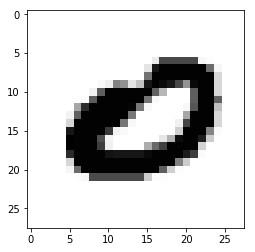

In [4]:
image, label = mnist.train.next_batch(1)
%matplotlib inline
print(label[0])
plt.imshow(image[0].reshape(28,28), cmap='Greys')

In [5]:
def discriminator(x, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        w1 = tf.get_variable("w1", [5, 5, 1, 32], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("b1", [32], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h1 = tf.nn.relu(tf.nn.conv2d(x, w1, [1, 2, 2, 1], "SAME") + b1)
        
        w2 = tf.get_variable("w2", [5, 5, 32, 64], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("b2", [64], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h2 = tf.nn.relu(tf.nn.conv2d(h1, w2, [1, 2, 2, 1], "SAME") + b2)
        
        w3 = tf.get_variable("w3", [5, 5, 64, 128], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("b3", [128], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h3 = tf.nn.relu(tf.nn.conv2d(h2, w3, [1, 2, 2, 1], "SAME") + b3)
                
        w4 = tf.get_variable("w4", [5, 5, 128, 256], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b4 = tf.get_variable("b4", [256], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h4 = tf.nn.relu(tf.nn.conv2d(h3, w4, [1, 2, 2, 1], "SAME") + b4)
        h4 = tf.reshape(h4, [-1, 256])
        
        w5 = tf.get_variable("w5", [256, 1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b5 = tf.get_variable("b5", [1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        return tf.matmul(h4, w5) + b5

In [6]:
def generator(z, zdim, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        w1 = tf.get_variable("w1", [zdim, 28 * 28 * 4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b1 = tf.get_variable("b1", [28 * 28 * 4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h1 = tf.nn.relu(tf.matmul(z, w1) + b1)
        h1 = tf.reshape(h1, [batch_size, 28 * 2, 28 * 2, 1])

        w2 = tf.get_variable("w2", [5, 5, 1, zdim/2], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable("b2", [zdim/2], initializer = tf.truncated_normal_initializer(stddev=0.02))
        bn2 = tf.nn.conv2d(h1, w2, [1, 2, 2, 1], "SAME") + b2
        h2 = tf.nn.relu(bn2)
        h2 = tf.image.resize_images(h2, [28*2, 28*2])
        
        
        w3 = tf.get_variable("w3", [5, 5, zdim/2, zdim/4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b3 = tf.get_variable("b3", [zdim/4], initializer = tf.truncated_normal_initializer(stddev=0.02))
        bn3 = tf.nn.conv2d(h2, w3, [1, 2, 2, 1], "SAME") + b3
        h3 = tf.nn.relu(bn3)
        h3 = tf.image.resize_images(h3, [28*2, 28*2])

        w4 = tf.get_variable("w4", [1, 1, zdim/4, 1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        b4 = tf.get_variable("b4", [1], initializer = tf.truncated_normal_initializer(stddev=0.02))
        h4 = tf.nn.conv2d(h3, w4, [1, 2, 2, 1], "SAME") + b4
        return tf.sigmoid(h4)


In [7]:
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name="x")
z_placeholder = tf.placeholder(tf.float32, [None, None], name="z")

In [8]:
session = tf.Session()
Dx = discriminator(x_placeholder)
Gz = generator(z_placeholder, 100, 100, False)
Dg = discriminator(Gz, True)

In [9]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_cost_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [10]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D/' in var.name]
g_vars = [var for var in tvars if 'G/' in var.name]

In [11]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)
optimizer_d_fake = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_fake, var_list=d_vars)
optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_cost, var_list=g_vars)

0
d_loss_real:
0.692943
d_loss_fake:
0.710446


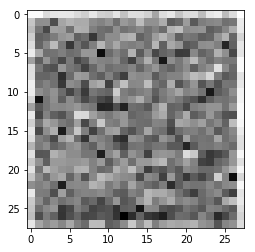

20
d_loss_real:
0.625879
d_loss_fake:
0.784624
40
d_loss_real:
0.587303
d_loss_fake:
0.984714
60
d_loss_real:
0.139434
d_loss_fake:
1.54846
80
d_loss_real:
0.0324816
d_loss_fake:
3.46514
100
d_loss_real:
0.0191487
d_loss_fake:
0.371724


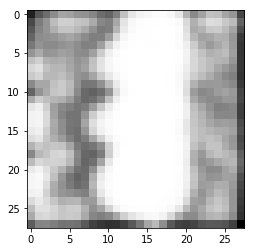

120
d_loss_real:
0.00385188
d_loss_fake:
0.0874977
140
d_loss_real:
5.39441e-05
d_loss_fake:
0.00174871
160
d_loss_real:
2.84677e-07
d_loss_fake:
0.000962394
180
d_loss_real:
8.71444e-06
d_loss_fake:
0.000461017
200
d_loss_real:
6.9831e-08
d_loss_fake:
0.000311111


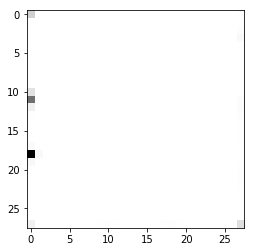

220
d_loss_real:
1.3775e-05
d_loss_fake:
0.000292759
240
d_loss_real:
7.98409e-08
d_loss_fake:
0.000270218
260
d_loss_real:
0.00986124
d_loss_fake:
1.13019
280
d_loss_real:
3.13321e-05
d_loss_fake:
0.0234074
300
d_loss_real:
0.373693
d_loss_fake:
6.8958


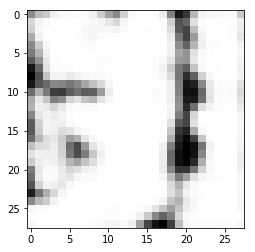

320
d_loss_real:
0.222399
d_loss_fake:
0.87665
340
d_loss_real:
0.191902
d_loss_fake:
1.8576
360
d_loss_real:
0.630669
d_loss_fake:
0.539819
380
d_loss_real:
0.402306
d_loss_fake:
0.744039
400
d_loss_real:
0.373012
d_loss_fake:
1.71288


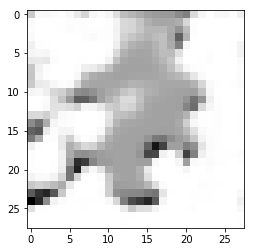

420
d_loss_real:
0.427185
d_loss_fake:
1.33004
440
d_loss_real:
0.322965
d_loss_fake:
1.60413
460
d_loss_real:
0.278503
d_loss_fake:
1.24852
480
d_loss_real:
0.571141
d_loss_fake:
1.41525
500
d_loss_real:
0.365957
d_loss_fake:
1.77181


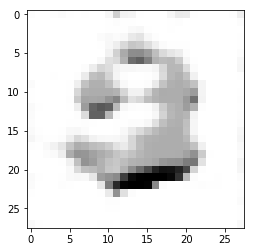

520
d_loss_real:
0.370382
d_loss_fake:
1.9027
540
d_loss_real:
0.359424
d_loss_fake:
1.95143
560
d_loss_real:
0.382501
d_loss_fake:
1.2429
580
d_loss_real:
0.318799
d_loss_fake:
1.2377
600
d_loss_real:
0.305971
d_loss_fake:
1.5419


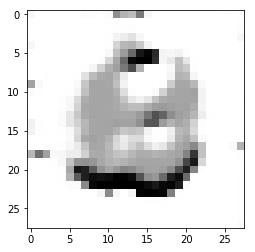

620
d_loss_real:
0.406343
d_loss_fake:
1.64654
640
d_loss_real:
0.327619
d_loss_fake:
1.39274
660
d_loss_real:
0.326114
d_loss_fake:
1.66996
680
d_loss_real:
0.184636
d_loss_fake:
2.69398
700
d_loss_real:
0.244085
d_loss_fake:
3.08051


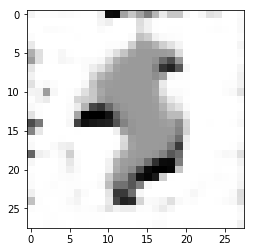

720
d_loss_real:
0.185721
d_loss_fake:
2.9828
740
d_loss_real:
0.19168
d_loss_fake:
1.82321
760
d_loss_real:
0.260195
d_loss_fake:
4.31078
780
d_loss_real:
0.325729
d_loss_fake:
3.60666
800
d_loss_real:
0.18497
d_loss_fake:
1.64785


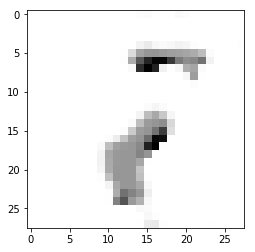

820
d_loss_real:
0.199803
d_loss_fake:
2.52855
840
d_loss_real:
0.321354
d_loss_fake:
4.67433
860
d_loss_real:
0.174096
d_loss_fake:
0.28036
880
d_loss_real:
0.135253
d_loss_fake:
2.06547
900
d_loss_real:
0.328059
d_loss_fake:
1.34497


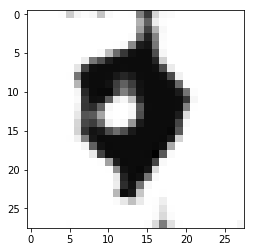

920
d_loss_real:
0.278561
d_loss_fake:
2.1395
940
d_loss_real:
0.243288
d_loss_fake:
2.09037
960
d_loss_real:
0.195917
d_loss_fake:
2.38096
980
d_loss_real:
0.167915
d_loss_fake:
1.57237
1000
d_loss_real:
0.196133
d_loss_fake:
1.646


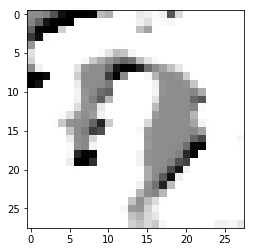

1020
d_loss_real:
0.185016
d_loss_fake:
1.18263
1040
d_loss_real:
0.205198
d_loss_fake:
3.92152
1060
d_loss_real:
0.194007
d_loss_fake:
3.5925
1080
d_loss_real:
0.185348
d_loss_fake:
1.79148
1100
d_loss_real:
0.185302
d_loss_fake:
1.99775


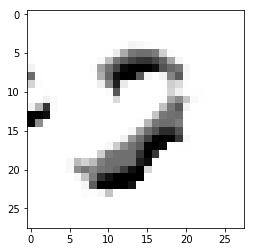

1120
d_loss_real:
0.179148
d_loss_fake:
3.55297
1140
d_loss_real:
0.207775
d_loss_fake:
3.6191
1160
d_loss_real:
0.192354
d_loss_fake:
4.37835
1180
d_loss_real:
0.24526
d_loss_fake:
3.68562
1200
d_loss_real:
0.199999
d_loss_fake:
2.14753


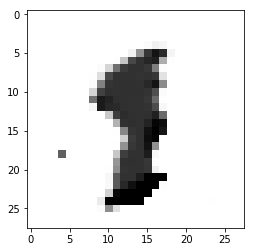

1220
d_loss_real:
0.197924
d_loss_fake:
2.30982
1240
d_loss_real:
0.183092
d_loss_fake:
4.61581
1260
d_loss_real:
0.239903
d_loss_fake:
3.9749
1280
d_loss_real:
0.234366
d_loss_fake:
3.34862
1300
d_loss_real:
0.201642
d_loss_fake:
3.23179


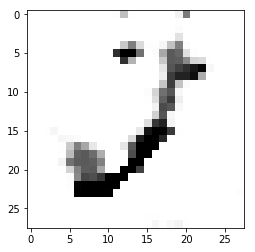

1320
d_loss_real:
0.265542
d_loss_fake:
4.10164
1340
d_loss_real:
0.222522
d_loss_fake:
3.56499
1360
d_loss_real:
0.222559
d_loss_fake:
3.68569
1380
d_loss_real:
0.255504
d_loss_fake:
3.58718
1400
d_loss_real:
0.298818
d_loss_fake:
4.25789


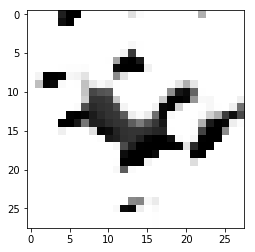

1420
d_loss_real:
0.232249
d_loss_fake:
3.98898
1440
d_loss_real:
0.242632
d_loss_fake:
3.83623
1460
d_loss_real:
0.278899
d_loss_fake:
4.04778
1480
d_loss_real:
0.301293
d_loss_fake:
3.0997
1500
d_loss_real:
0.265959
d_loss_fake:
2.9699


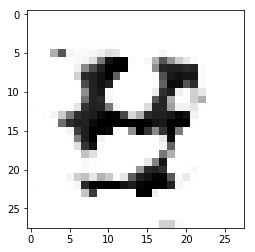

1520
d_loss_real:
0.242836
d_loss_fake:
3.3761
1540
d_loss_real:
0.313119
d_loss_fake:
3.73488
1560
d_loss_real:
0.203874
d_loss_fake:
3.35014
1580
d_loss_real:
0.259269
d_loss_fake:
3.01157
1600
d_loss_real:
0.255817
d_loss_fake:
3.36405


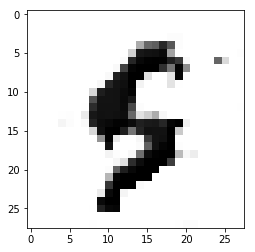

1620
d_loss_real:
0.254756
d_loss_fake:
3.28155
1640
d_loss_real:
0.191788
d_loss_fake:
3.29304
1660
d_loss_real:
0.314296
d_loss_fake:
3.1752
1680
d_loss_real:
0.350022
d_loss_fake:
4.01816
1700
d_loss_real:
0.2501
d_loss_fake:
6.9267


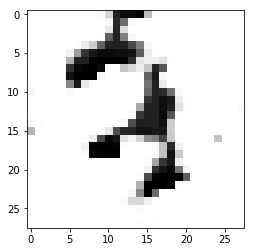

1720
d_loss_real:
0.26182
d_loss_fake:
3.33726
1740
d_loss_real:
0.263483
d_loss_fake:
3.7609
1760
d_loss_real:
0.240995
d_loss_fake:
3.55571
1780
d_loss_real:
0.248195
d_loss_fake:
4.71043
1800
d_loss_real:
0.238138
d_loss_fake:
3.5073


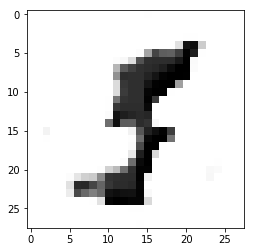

1820
d_loss_real:
0.250816
d_loss_fake:
3.78036
1840
d_loss_real:
0.231483
d_loss_fake:
3.20357
1860
d_loss_real:
0.264835
d_loss_fake:
2.93799
1880
d_loss_real:
0.258812
d_loss_fake:
3.61286
1900
d_loss_real:
0.216885
d_loss_fake:
3.88881


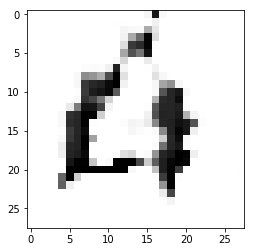

1920
d_loss_real:
0.325701
d_loss_fake:
3.17822
1940
d_loss_real:
0.233859
d_loss_fake:
4.45902
1960
d_loss_real:
0.210943
d_loss_fake:
3.72618
1980
d_loss_real:
0.306692
d_loss_fake:
2.99501
2000
d_loss_real:
0.218009
d_loss_fake:
4.09436


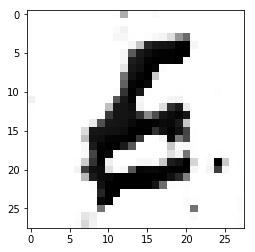

2020
d_loss_real:
0.181417
d_loss_fake:
3.99706
2040
d_loss_real:
0.247356
d_loss_fake:
3.36024
2060
d_loss_real:
0.276601
d_loss_fake:
3.42445
2080
d_loss_real:
0.265077
d_loss_fake:
3.86155
2100
d_loss_real:
0.340088
d_loss_fake:
3.82904


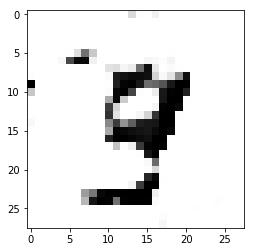

2120
d_loss_real:
0.327182
d_loss_fake:
5.74513
2140
d_loss_real:
0.271593
d_loss_fake:
3.06959
2160
d_loss_real:
0.269035
d_loss_fake:
2.61303
2180
d_loss_real:
0.276762
d_loss_fake:
1.97977
2200
d_loss_real:
0.371968
d_loss_fake:
8.20002


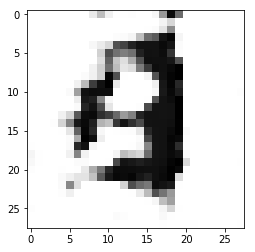

2220
d_loss_real:
0.28434
d_loss_fake:
3.16895
2240
d_loss_real:
0.199267
d_loss_fake:
2.2242
2260
d_loss_real:
0.289702
d_loss_fake:
4.06785
2280
d_loss_real:
0.236403
d_loss_fake:
3.30353
2300
d_loss_real:
0.3417
d_loss_fake:
3.74007


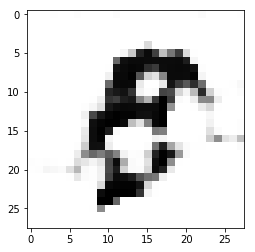

2320
d_loss_real:
0.200056
d_loss_fake:
1.28975
2340
d_loss_real:
0.305153
d_loss_fake:
3.54069
2360
d_loss_real:
0.294185
d_loss_fake:
2.30446
2380
d_loss_real:
0.287285
d_loss_fake:
3.8155
2400
d_loss_real:
0.322102
d_loss_fake:
3.79803


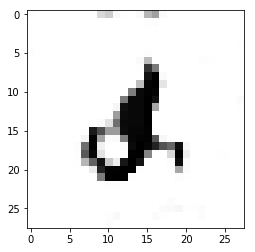

2420
d_loss_real:
0.340206
d_loss_fake:
4.00045
2440
d_loss_real:
0.277203
d_loss_fake:
1.91097
2460
d_loss_real:
0.618291
d_loss_fake:
4.33725
2480
d_loss_real:
0.216569
d_loss_fake:
2.24059
2500
d_loss_real:
1.39465
d_loss_fake:
1.26743


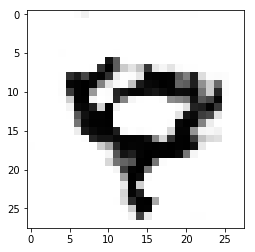

2520
d_loss_real:
0.500518
d_loss_fake:
3.04398
2540
d_loss_real:
0.385475
d_loss_fake:
4.03636
2560
d_loss_real:
0.356401
d_loss_fake:
1.19797
2580
d_loss_real:
0.256649
d_loss_fake:
5.73554
2600
d_loss_real:
0.495396
d_loss_fake:
1.42376


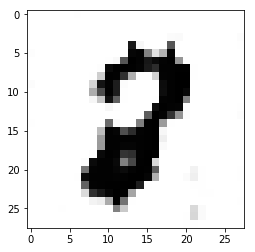

2620
d_loss_real:
0.318884
d_loss_fake:
3.37338
2640
d_loss_real:
0.511821
d_loss_fake:
4.28829
2660
d_loss_real:
0.233171
d_loss_fake:
2.8138
2680
d_loss_real:
0.47631
d_loss_fake:
5.38769
2700
d_loss_real:
0.408747
d_loss_fake:
1.74388


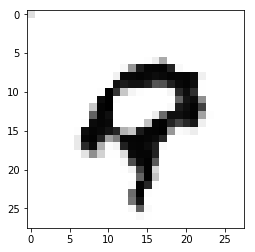

2720
d_loss_real:
0.501013
d_loss_fake:
4.98429
2740
d_loss_real:
0.372374
d_loss_fake:
3.38225
2760
d_loss_real:
0.326809
d_loss_fake:
3.5786
2780
d_loss_real:
0.147815
d_loss_fake:
5.15258
2800
d_loss_real:
0.522335
d_loss_fake:
3.72751


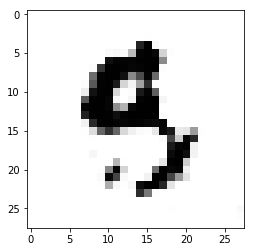

2820
d_loss_real:
0.353131
d_loss_fake:
4.17101
2840
d_loss_real:
0.374285
d_loss_fake:
3.15521
2860
d_loss_real:
0.316169
d_loss_fake:
3.84094
2880
d_loss_real:
0.325422
d_loss_fake:
4.07402
2900
d_loss_real:
0.32395
d_loss_fake:
4.02409


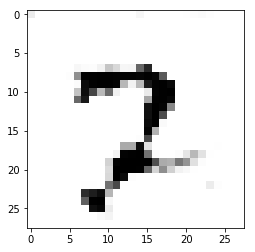

2920
d_loss_real:
0.557974
d_loss_fake:
2.93792
2940
d_loss_real:
0.261011
d_loss_fake:
3.5122
2960
d_loss_real:
0.321068
d_loss_fake:
2.28178
2980
d_loss_real:
0.336376
d_loss_fake:
5.49497
3000
d_loss_real:
0.320318
d_loss_fake:
5.31526


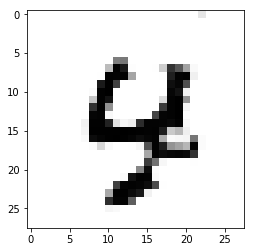

3020
d_loss_real:
0.183019
d_loss_fake:
2.77859
3040
d_loss_real:
0.115821
d_loss_fake:
6.21553
3060
d_loss_real:
0.386399
d_loss_fake:
4.82653
3080
d_loss_real:
0.292538
d_loss_fake:
3.18028
3100
d_loss_real:
0.520115
d_loss_fake:
3.57694


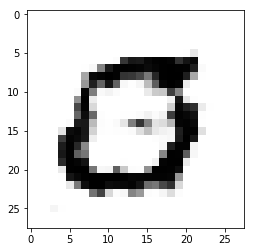

3120
d_loss_real:
0.325563
d_loss_fake:
4.75205
3140
d_loss_real:
0.46141
d_loss_fake:
1.87935
3160
d_loss_real:
0.575953
d_loss_fake:
4.89704
3180
d_loss_real:
0.265626
d_loss_fake:
5.2296
3200
d_loss_real:
0.715365
d_loss_fake:
4.05414


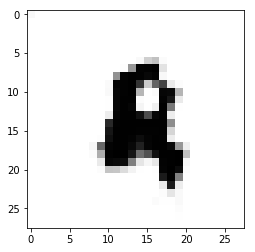

3220
d_loss_real:
0.761485
d_loss_fake:
3.16361
3240
d_loss_real:
0.357648
d_loss_fake:
3.9425
3260
d_loss_real:
0.377604
d_loss_fake:
4.61736
3280
d_loss_real:
0.374552
d_loss_fake:
4.17053
3300
d_loss_real:
0.296609
d_loss_fake:
4.47927


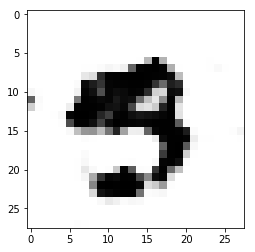

3320
d_loss_real:
0.180127
d_loss_fake:
5.69548
3340
d_loss_real:
0.15651
d_loss_fake:
3.80159
3360
d_loss_real:
0.365125
d_loss_fake:
5.4749
3380
d_loss_real:
0.279624
d_loss_fake:
6.68031
3400
d_loss_real:
0.465042
d_loss_fake:
4.80837


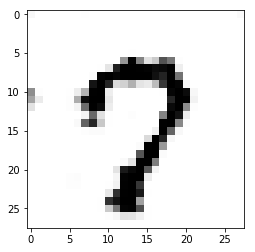

3420
d_loss_real:
0.384616
d_loss_fake:
6.35687
3440
d_loss_real:
0.553052
d_loss_fake:
5.44739
3460
d_loss_real:
0.538343
d_loss_fake:
5.97474
3480
d_loss_real:
0.423655
d_loss_fake:
4.84982
3500
d_loss_real:
0.703321
d_loss_fake:
2.21688


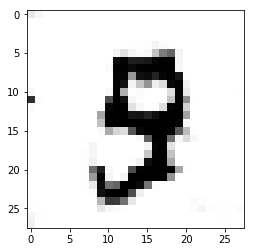

3520
d_loss_real:
0.267521
d_loss_fake:
8.05354
3540
d_loss_real:
0.116813
d_loss_fake:
4.74543
3560
d_loss_real:
0.154229
d_loss_fake:
7.31937
3580
d_loss_real:
0.612027
d_loss_fake:
5.75051
3600
d_loss_real:
0.289667
d_loss_fake:
7.70114


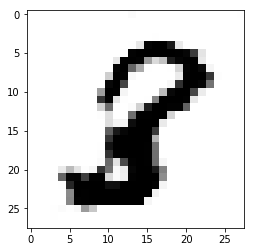

3620
d_loss_real:
1.34979
d_loss_fake:
4.2921
3640
d_loss_real:
1.63926
d_loss_fake:
3.88587
3660
d_loss_real:
1.9165
d_loss_fake:
10.4345
3680
d_loss_real:
0.613816
d_loss_fake:
8.19102
3700
d_loss_real:
0.582476
d_loss_fake:
7.40053


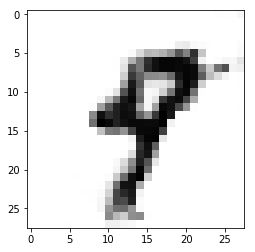

3720
d_loss_real:
0.863967
d_loss_fake:
11.6628
3740
d_loss_real:
0.831427
d_loss_fake:
10.8342
3760
d_loss_real:
1.09747
d_loss_fake:
17.966
3780
d_loss_real:
1.52758
d_loss_fake:
19.2442
3800
d_loss_real:
2.80721
d_loss_fake:
12.5136


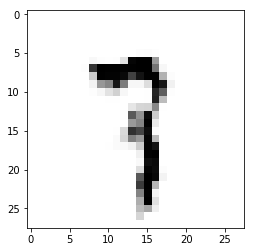

3820
d_loss_real:
7.85902
d_loss_fake:
43.2773
3840
d_loss_real:
3.69741
d_loss_fake:
24.9746
3860
d_loss_real:
8.66788
d_loss_fake:
167.937
3880
d_loss_real:
1.4333
d_loss_fake:
7.80499
3900
d_loss_real:
1.52694
d_loss_fake:
54.1206


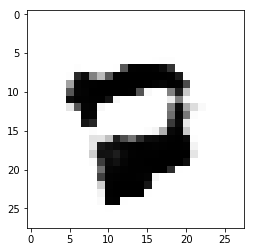

3920
d_loss_real:
5.90785
d_loss_fake:
37.7066
3940
d_loss_real:
3.30234
d_loss_fake:
46.1112
3960
d_loss_real:
7.53228
d_loss_fake:
69.9119
3980
d_loss_real:
1.61966
d_loss_fake:
83.3564
4000
d_loss_real:
12.2505
d_loss_fake:
92.3627


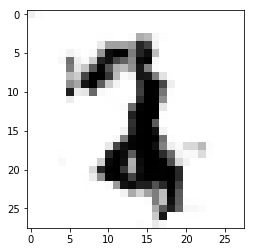

4020
d_loss_real:
6.18454
d_loss_fake:
83.747
4040
d_loss_real:
10.9388
d_loss_fake:
130.06
4060
d_loss_real:
8.35143
d_loss_fake:
71.4606
4080
d_loss_real:
2.4163
d_loss_fake:
89.0361
4100
d_loss_real:
10.149
d_loss_fake:
111.711


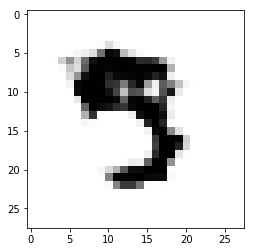

4120
d_loss_real:
8.63804
d_loss_fake:
60.0238
4140
d_loss_real:
8.23029
d_loss_fake:
108.576
4160
d_loss_real:
7.90825
d_loss_fake:
87.5411
4180
d_loss_real:
10.3782
d_loss_fake:
113.495
4200
d_loss_real:
5.65101
d_loss_fake:
109.293


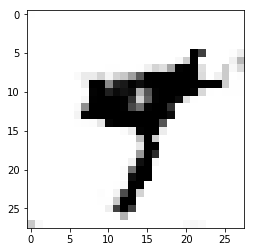

4220
d_loss_real:
8.40769
d_loss_fake:
102.324
4240
d_loss_real:
1.93352
d_loss_fake:
108.42
4260
d_loss_real:
4.69651
d_loss_fake:
97.9371
4280
d_loss_real:
6.77952
d_loss_fake:
109.916
4300
d_loss_real:
4.55672
d_loss_fake:
112.284


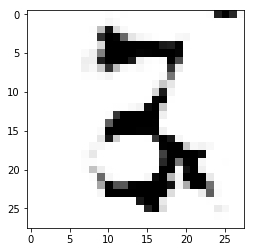

4320
d_loss_real:
4.60706
d_loss_fake:
93.924
4340
d_loss_real:
4.00955
d_loss_fake:
93.7018
4360
d_loss_real:
9.71712
d_loss_fake:
117.418
4380
d_loss_real:
5.68628
d_loss_fake:
111.551
4400
d_loss_real:
11.4877
d_loss_fake:
126.261


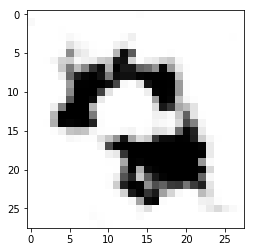

4420
d_loss_real:
4.01625
d_loss_fake:
118.108
4440
d_loss_real:
9.43628
d_loss_fake:
104.801
4460
d_loss_real:
8.61934
d_loss_fake:
115.344
4480
d_loss_real:
11.4
d_loss_fake:
121.802
4500
d_loss_real:
13.3442
d_loss_fake:
25.8637


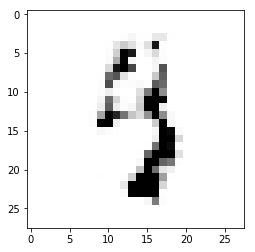

4520
d_loss_real:
30.9593
d_loss_fake:
119.719
4540
d_loss_real:
14.9943
d_loss_fake:
35.0254
4560
d_loss_real:
11.791
d_loss_fake:
27.3575
4580
d_loss_real:
20.355
d_loss_fake:
62.1553
4600
d_loss_real:
18.308
d_loss_fake:
155.921


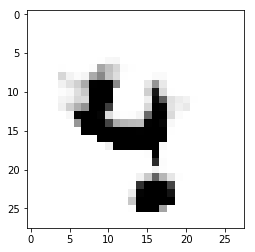

4620
d_loss_real:
12.5586
d_loss_fake:
131.465
4640
d_loss_real:
3.25901
d_loss_fake:
120.37
4660
d_loss_real:
5.48915
d_loss_fake:
42.0765
4680
d_loss_real:
14.5002
d_loss_fake:
103.378
4700
d_loss_real:
9.07645
d_loss_fake:
132.318


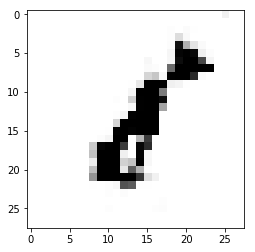

4720
d_loss_real:
7.78995
d_loss_fake:
106.174
4740
d_loss_real:
11.5763
d_loss_fake:
95.51
4760
d_loss_real:
6.10192
d_loss_fake:
97.2981
4780
d_loss_real:
19.3419
d_loss_fake:
105.879
4800
d_loss_real:
23.0261
d_loss_fake:
92.1417


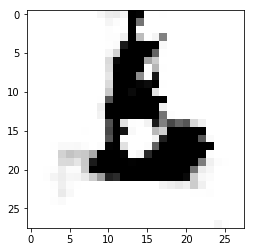

4820
d_loss_real:
14.0053
d_loss_fake:
123.872
4840
d_loss_real:
20.6401
d_loss_fake:
126.259
4860
d_loss_real:
8.21106
d_loss_fake:
97.332
4880
d_loss_real:
11.1672
d_loss_fake:
117.563
4900
d_loss_real:
58.4285
d_loss_fake:
57.5797


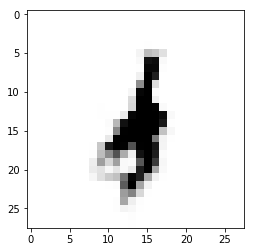

4920
d_loss_real:
22.9925
d_loss_fake:
242.051
4940
d_loss_real:
19.407
d_loss_fake:
120.088
4960
d_loss_real:
22.9876
d_loss_fake:
141.832
4980
d_loss_real:
22.4538
d_loss_fake:
190.688
5000
d_loss_real:
21.035
d_loss_fake:
149.506


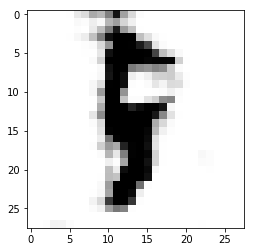

5020
d_loss_real:
24.1291
d_loss_fake:
127.859
5040
d_loss_real:
18.9666
d_loss_fake:
209.268
5060
d_loss_real:
9.45915
d_loss_fake:
277.974
5080
d_loss_real:
30.4453
d_loss_fake:
210.759
5100
d_loss_real:
9.82429
d_loss_fake:
363.647


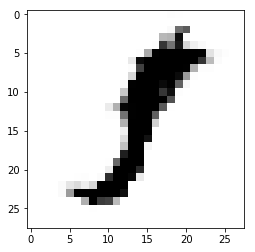

5120
d_loss_real:
24.0259
d_loss_fake:
294.223
5140
d_loss_real:
28.7078
d_loss_fake:
192.486
5160
d_loss_real:
17.7734
d_loss_fake:
363.02
5180
d_loss_real:
30.8313
d_loss_fake:
123.228
5200
d_loss_real:
11.3733
d_loss_fake:
430.441


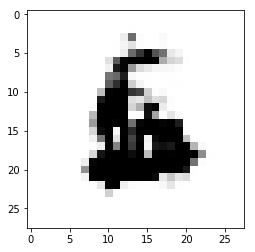

5220
d_loss_real:
58.2317
d_loss_fake:
323.594
5240
d_loss_real:
18.374
d_loss_fake:
112.566
5260
d_loss_real:
13.5563
d_loss_fake:
330.838
5280
d_loss_real:
17.3719
d_loss_fake:
467.609
5300
d_loss_real:
22.7894
d_loss_fake:
391.27


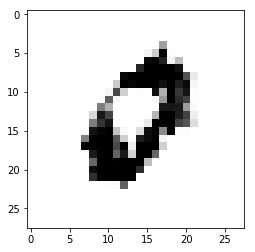

5320
d_loss_real:
26.2473
d_loss_fake:
481.266
5340
d_loss_real:
38.6803
d_loss_fake:
457.101
5360
d_loss_real:
24.1082
d_loss_fake:
387.644
5380
d_loss_real:
28.7805
d_loss_fake:
457.059
5400
d_loss_real:
19.4157
d_loss_fake:
482.346


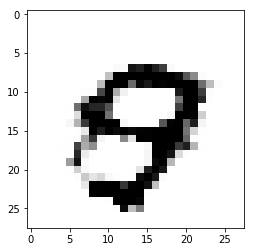

5420
d_loss_real:
14.4861
d_loss_fake:
485.474
5440
d_loss_real:
15.5214
d_loss_fake:
560.266
5460
d_loss_real:
63.766
d_loss_fake:
443.92
5480
d_loss_real:
55.3028
d_loss_fake:
149.153
5500
d_loss_real:
18.2328
d_loss_fake:
286.924


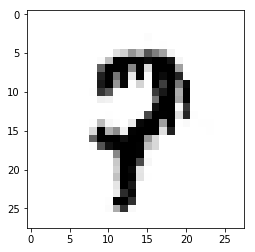

5520
d_loss_real:
86.7174
d_loss_fake:
482.593
5540
d_loss_real:
85.321
d_loss_fake:
269.684
5560
d_loss_real:
45.7085
d_loss_fake:
781.231
5580
d_loss_real:
155.727
d_loss_fake:
846.826
5600
d_loss_real:
40.2777
d_loss_fake:
126.123


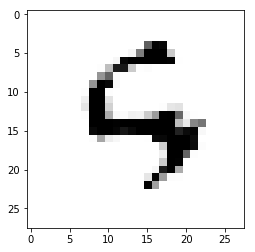

5620
d_loss_real:
221.984
d_loss_fake:
1136.31
5640
d_loss_real:
78.1687
d_loss_fake:
524.842
5660
d_loss_real:
131.886
d_loss_fake:
778.794
5680
d_loss_real:
44.4755
d_loss_fake:
125.966
5700
d_loss_real:
168.438
d_loss_fake:
334.523


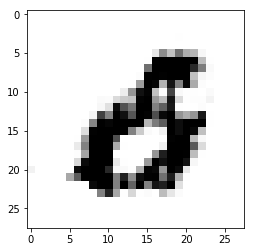

5720
d_loss_real:
119.598
d_loss_fake:
544.155
5740
d_loss_real:
83.8467
d_loss_fake:
710.152
5760
d_loss_real:
76.4121
d_loss_fake:
320.367
5780
d_loss_real:
93.6031
d_loss_fake:
494.627
5800
d_loss_real:
37.1736
d_loss_fake:
208.928


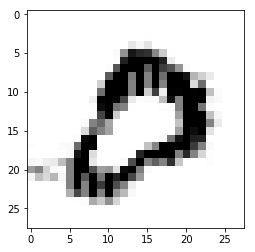

5820
d_loss_real:
253.864
d_loss_fake:
69.573
5840
d_loss_real:
28.3729
d_loss_fake:
146.861
5860
d_loss_real:
54.6275
d_loss_fake:
410.653
5880
d_loss_real:
42.6815
d_loss_fake:
698.57
5900
d_loss_real:
110.078
d_loss_fake:
591.961


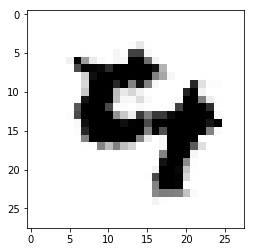

5920
d_loss_real:
49.5628
d_loss_fake:
185.479
5940
d_loss_real:
35.4273
d_loss_fake:
649.251
5960
d_loss_real:
52.4796
d_loss_fake:
714.183
5980
d_loss_real:
61.2896
d_loss_fake:
721.698
6000
d_loss_real:
64.8941
d_loss_fake:
702.865


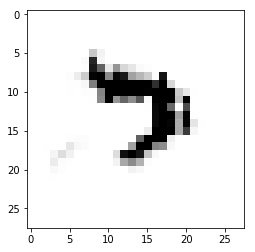

6020
d_loss_real:
59.1453
d_loss_fake:
627.345
6040
d_loss_real:
40.5352
d_loss_fake:
517.858
6060
d_loss_real:
27.2138
d_loss_fake:
597.598
6080
d_loss_real:
53.7676
d_loss_fake:
415.419
6100
d_loss_real:
41.4363
d_loss_fake:
766.385


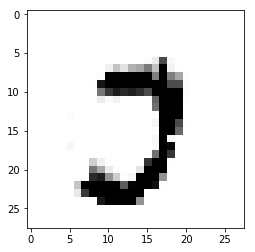

6120
d_loss_real:
49.6781
d_loss_fake:
512.066
6140
d_loss_real:
27.4083
d_loss_fake:
289.258
6160
d_loss_real:
51.7906
d_loss_fake:
507.496
6180
d_loss_real:
48.9823
d_loss_fake:
804.357
6200
d_loss_real:
51.3776
d_loss_fake:
807.226


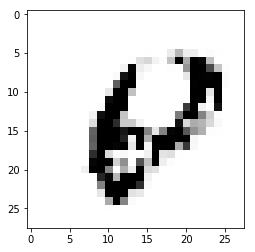

6220
d_loss_real:
72.1674
d_loss_fake:
701.365
6240
d_loss_real:
52.9678
d_loss_fake:
702.51
6260
d_loss_real:
32.3842
d_loss_fake:
201.923
6280
d_loss_real:
61.8779
d_loss_fake:
411.773
6300
d_loss_real:
59.7735
d_loss_fake:
793.743


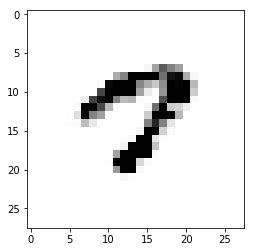

6320
d_loss_real:
47.2937
d_loss_fake:
848.177
6340
d_loss_real:
36.0056
d_loss_fake:
877.496
6360
d_loss_real:
40.3962
d_loss_fake:
901.159
6380
d_loss_real:
16.4205
d_loss_fake:
922.278
6400
d_loss_real:
27.459
d_loss_fake:
911.84


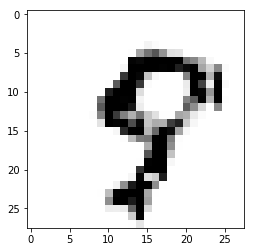

6420
d_loss_real:
42.903
d_loss_fake:
251.772
6440
d_loss_real:
31.2053
d_loss_fake:
828.031
6460
d_loss_real:
29.1673
d_loss_fake:
842.11
6480
d_loss_real:
38.4903
d_loss_fake:
1058.36
6500
d_loss_real:
49.8613
d_loss_fake:
844.011


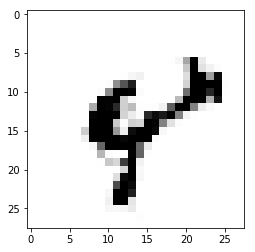

6520
d_loss_real:
40.1033
d_loss_fake:
888.778
6540
d_loss_real:
45.3821
d_loss_fake:
996.788
6560
d_loss_real:
28.7201
d_loss_fake:
909.38
6580
d_loss_real:
36.1614
d_loss_fake:
493.269
6600
d_loss_real:
23.7439
d_loss_fake:
907.649


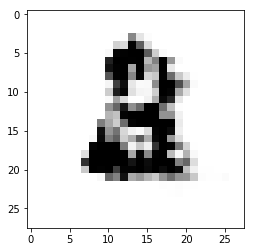

6620
d_loss_real:
19.2029
d_loss_fake:
818.872
6640
d_loss_real:
71.0685
d_loss_fake:
587.952
6660
d_loss_real:
32.1752
d_loss_fake:
947.51
6680
d_loss_real:
33.7182
d_loss_fake:
882.992
6700
d_loss_real:
35.1828
d_loss_fake:
937.121


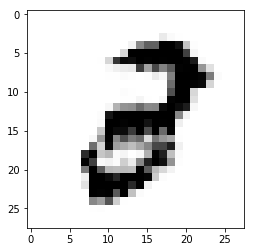

6720
d_loss_real:
17.5513
d_loss_fake:
902.015
6740
d_loss_real:
43.8551
d_loss_fake:
836.345
6760
d_loss_real:
77.2769
d_loss_fake:
845.722
6780
d_loss_real:
85.4412
d_loss_fake:
969.573
6800
d_loss_real:
40.7539
d_loss_fake:
838.719


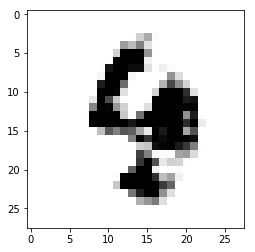

6820
d_loss_real:
110.291
d_loss_fake:
833.039
6840
d_loss_real:
68.493
d_loss_fake:
711.455
6860
d_loss_real:
69.7086
d_loss_fake:
807.872
6880
d_loss_real:
44.3603
d_loss_fake:
942.291
6900
d_loss_real:
48.9958
d_loss_fake:
792.356


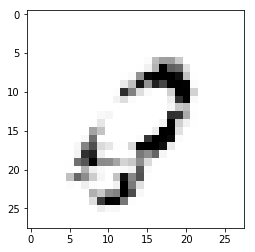

6920
d_loss_real:
32.8996
d_loss_fake:
767.625
6940
d_loss_real:
68.657
d_loss_fake:
985.901
6960
d_loss_real:
148.067
d_loss_fake:
852.042
6980
d_loss_real:
48.3903
d_loss_fake:
915.272
7000
d_loss_real:
135.206
d_loss_fake:
777.615


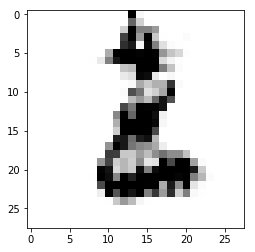

7020
d_loss_real:
97.2031
d_loss_fake:
904.858
7040
d_loss_real:
124.476
d_loss_fake:
926.565
7060
d_loss_real:
80.334
d_loss_fake:
347.021
7080
d_loss_real:
186.693
d_loss_fake:
737.393
7100
d_loss_real:
110.745
d_loss_fake:
776.608


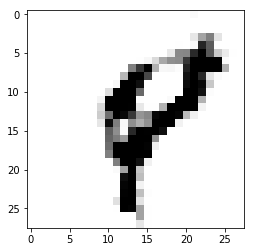

7120
d_loss_real:
270.004
d_loss_fake:
628.633
7140
d_loss_real:
95.477
d_loss_fake:
652.458
7160
d_loss_real:
87.4429
d_loss_fake:
270.226
7180
d_loss_real:
207.317
d_loss_fake:
1149.54
7200
d_loss_real:
158.471
d_loss_fake:
737.366


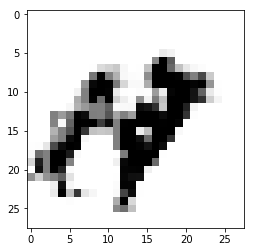

7220
d_loss_real:
213.724
d_loss_fake:
809.51
7240
d_loss_real:
92.2418
d_loss_fake:
542.611
7260
d_loss_real:
75.002
d_loss_fake:
469.426
7280
d_loss_real:
93.4978
d_loss_fake:
1003.2
7300
d_loss_real:
84.6509
d_loss_fake:
772.213


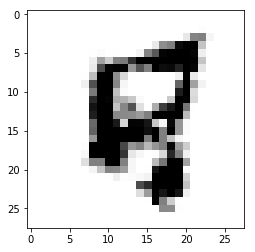

7320
d_loss_real:
110.055
d_loss_fake:
748.482
7340
d_loss_real:
83.4327
d_loss_fake:
556.502
7360
d_loss_real:
90.5846
d_loss_fake:
507.536
7380
d_loss_real:
73.2353
d_loss_fake:
837.329
7400
d_loss_real:
75.8976
d_loss_fake:
809.062


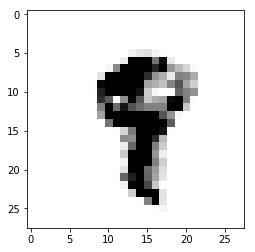

7420
d_loss_real:
103.031
d_loss_fake:
721.543
7440
d_loss_real:
31.8175
d_loss_fake:
754.822
7460
d_loss_real:
50.063
d_loss_fake:
712.196
7480
d_loss_real:
56.4565
d_loss_fake:
1232.1
7500
d_loss_real:
51.1166
d_loss_fake:
847.912


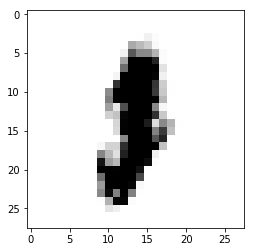

7520
d_loss_real:
41.1233
d_loss_fake:
851.034
7540
d_loss_real:
25.4819
d_loss_fake:
306.583
7560
d_loss_real:
66.8333
d_loss_fake:
699.062
7580
d_loss_real:
61.2906
d_loss_fake:
763.238
7600
d_loss_real:
44.863
d_loss_fake:
801.1


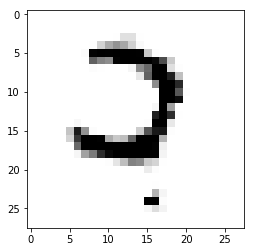

7620
d_loss_real:
29.6221
d_loss_fake:
825.572
7640
d_loss_real:
72.541
d_loss_fake:
758.927
7660
d_loss_real:
51.4531
d_loss_fake:
697.866
7680
d_loss_real:
74.1228
d_loss_fake:
747.724
7700
d_loss_real:
67.7232
d_loss_fake:
770.711


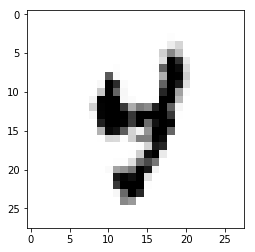

7720
d_loss_real:
27.134
d_loss_fake:
826.422
7740
d_loss_real:
60.6001
d_loss_fake:
755.327
7760
d_loss_real:
58.9016
d_loss_fake:
291.386
7780
d_loss_real:
42.7187
d_loss_fake:
745.472
7800
d_loss_real:
60.8808
d_loss_fake:
773.379


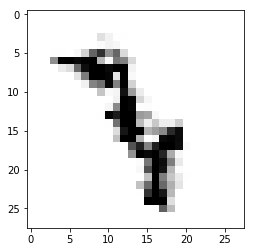

7820
d_loss_real:
26.4036
d_loss_fake:
889.512
7840
d_loss_real:
56.8921
d_loss_fake:
744.839
7860
d_loss_real:
88.3166
d_loss_fake:
745.481
7880
d_loss_real:
12.8108
d_loss_fake:
838.546
7900
d_loss_real:
69.6762
d_loss_fake:
713.975


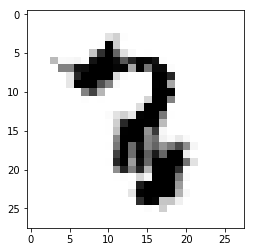

7920
d_loss_real:
47.8885
d_loss_fake:
739.938
7940
d_loss_real:
45.5649
d_loss_fake:
750.798
7960
d_loss_real:
95.0526
d_loss_fake:
236.908
7980
d_loss_real:
27.5574
d_loss_fake:
796.507
8000
d_loss_real:
44.203
d_loss_fake:
761.642


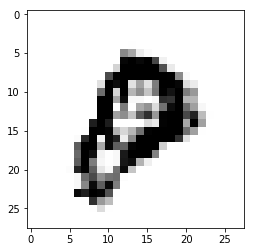

8020
d_loss_real:
60.7431
d_loss_fake:
736.624
8040
d_loss_real:
36.9128
d_loss_fake:
735.179
8060
d_loss_real:
74.2956
d_loss_fake:
692.044
8080
d_loss_real:
37.7289
d_loss_fake:
737.113
8100
d_loss_real:
37.567
d_loss_fake:
690.621


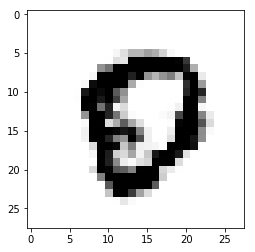

8120
d_loss_real:
84.9674
d_loss_fake:
681.73
8140
d_loss_real:
29.7992
d_loss_fake:
814.954
8160
d_loss_real:
33.4624
d_loss_fake:
755.727
8180
d_loss_real:
59.8617
d_loss_fake:
443.553
8200
d_loss_real:
42.2778
d_loss_fake:
775.779


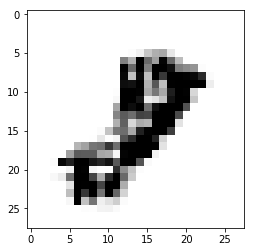

8220
d_loss_real:
39.311
d_loss_fake:
747.71
8240
d_loss_real:
43.8207
d_loss_fake:
752.457
8260
d_loss_real:
35.9289
d_loss_fake:
715.748
8280
d_loss_real:
63.9621
d_loss_fake:
631.921
8300
d_loss_real:
53.8038
d_loss_fake:
712.84


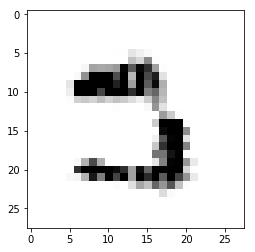

8320
d_loss_real:
40.8225
d_loss_fake:
726.659
8340
d_loss_real:
55.9323
d_loss_fake:
751.622
8360
d_loss_real:
26.1666
d_loss_fake:
749.025
8380
d_loss_real:
35.47
d_loss_fake:
739.92
8400
d_loss_real:
23.5303
d_loss_fake:
704.353


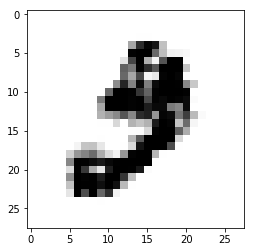

8420
d_loss_real:
61.741
d_loss_fake:
696.317
8440
d_loss_real:
27.387
d_loss_fake:
706.051
8460
d_loss_real:
18.5715
d_loss_fake:
717.085
8480
d_loss_real:
119.163
d_loss_fake:
610.031
8500
d_loss_real:
34.7837
d_loss_fake:
740.698


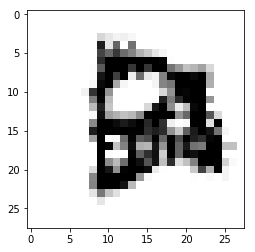

8520
d_loss_real:
60.2428
d_loss_fake:
658.528
8540
d_loss_real:
65.4884
d_loss_fake:
630.26
8560
d_loss_real:
28.1142
d_loss_fake:
672.622
8580
d_loss_real:
44.2017
d_loss_fake:
723.133
8600
d_loss_real:
78.9597
d_loss_fake:
596.032


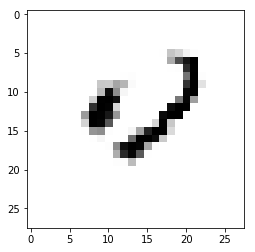

8620
d_loss_real:
65.6809
d_loss_fake:
716.134
8640
d_loss_real:
69.2474
d_loss_fake:
647.338
8660
d_loss_real:
71.0776
d_loss_fake:
283.878
8680
d_loss_real:
86.5344
d_loss_fake:
696.86
8700
d_loss_real:
86.343
d_loss_fake:
625.745


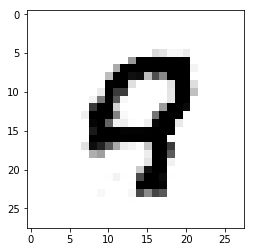

8720
d_loss_real:
21.2213
d_loss_fake:
546.553
8740
d_loss_real:
130.969
d_loss_fake:
488.983
8760
d_loss_real:
63.8316
d_loss_fake:
683.221
8780
d_loss_real:
72.1632
d_loss_fake:
622.544
8800
d_loss_real:
53.2162
d_loss_fake:
462.004


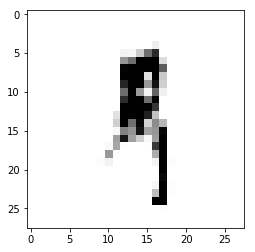

8820
d_loss_real:
129.988
d_loss_fake:
451.72
8840
d_loss_real:
21.8362
d_loss_fake:
732.047
8860
d_loss_real:
117.84
d_loss_fake:
504.484
8880
d_loss_real:
66.6251
d_loss_fake:
505.224
8900
d_loss_real:
110.927
d_loss_fake:
57.7843


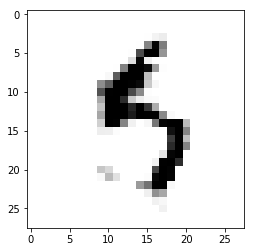

8920
d_loss_real:
150.64
d_loss_fake:
624.329
8940
d_loss_real:
63.6722
d_loss_fake:
479.863
8960
d_loss_real:
182.947
d_loss_fake:
443.858
8980
d_loss_real:
45.9543
d_loss_fake:
511.115
9000
d_loss_real:
100.93
d_loss_fake:
370.239


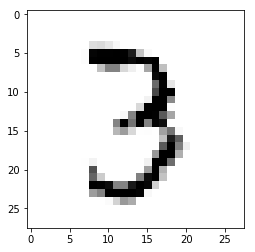

9020
d_loss_real:
100.283
d_loss_fake:
551.191
9040
d_loss_real:
45.4615
d_loss_fake:
515.645
9060
d_loss_real:
72.8948
d_loss_fake:
439.417
9080
d_loss_real:
39.1916
d_loss_fake:
496.01
9100
d_loss_real:
58.316
d_loss_fake:
365.024


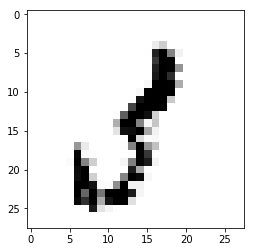

9120
d_loss_real:
31.5972
d_loss_fake:
558.66
9140
d_loss_real:
56.8659
d_loss_fake:
513.197
9160
d_loss_real:
42.3805
d_loss_fake:
482.999
9180
d_loss_real:
22.3559
d_loss_fake:
43.908
9200
d_loss_real:
33.1225
d_loss_fake:
456.385


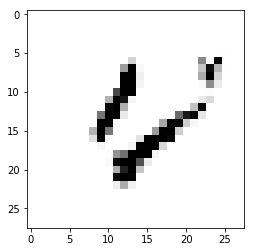

9220
d_loss_real:
22.0162
d_loss_fake:
490.968
9240
d_loss_real:
34.3222
d_loss_fake:
477.318
9260
d_loss_real:
35.5116
d_loss_fake:
405.844
9280
d_loss_real:
28.4111
d_loss_fake:
453.435
9300
d_loss_real:
30.9771
d_loss_fake:
349.02


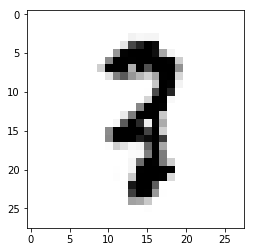

9320
d_loss_real:
21.0505
d_loss_fake:
487.865
9340
d_loss_real:
32.4817
d_loss_fake:
474.49
9360
d_loss_real:
31.3701
d_loss_fake:
461.498
9380
d_loss_real:
27.0925
d_loss_fake:
169.397
9400
d_loss_real:
26.2405
d_loss_fake:
458.075


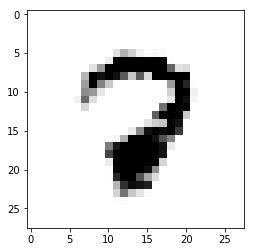

9420
d_loss_real:
21.5819
d_loss_fake:
446.451
9440
d_loss_real:
47.3945
d_loss_fake:
246.301
9460
d_loss_real:
39.1159
d_loss_fake:
429.376
9480
d_loss_real:
31.4406
d_loss_fake:
403.606
9500
d_loss_real:
28.033
d_loss_fake:
419.879


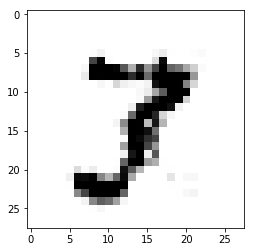

9520
d_loss_real:
24.5996
d_loss_fake:
417.377
9540
d_loss_real:
28.9193
d_loss_fake:
412.608
9560
d_loss_real:
21.3616
d_loss_fake:
403.652
9580
d_loss_real:
42.2955
d_loss_fake:
385.852
9600
d_loss_real:
15.1442
d_loss_fake:
383.588


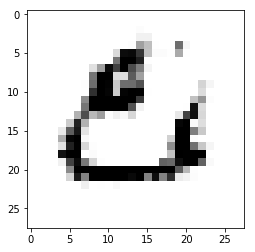

9620
d_loss_real:
23.8189
d_loss_fake:
386.668
9640
d_loss_real:
20.9574
d_loss_fake:
401.17
9660
d_loss_real:
49.8956
d_loss_fake:
387.237
9680
d_loss_real:
28.9079
d_loss_fake:
375.141
9700
d_loss_real:
29.9135
d_loss_fake:
369.336


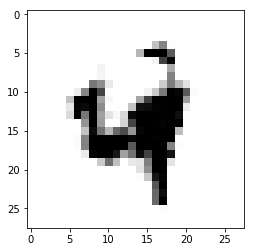

9720
d_loss_real:
19.5811
d_loss_fake:
379.397
9740
d_loss_real:
24.7557
d_loss_fake:
38.5408
9760
d_loss_real:
26.9382
d_loss_fake:
375.651
9780
d_loss_real:
33.3845
d_loss_fake:
363.389
9800
d_loss_real:
47.5307
d_loss_fake:
410.265


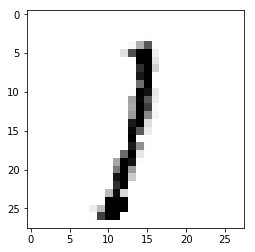

9820
d_loss_real:
31.4011
d_loss_fake:
369.676
9840
d_loss_real:
37.9949
d_loss_fake:
337.982
9860
d_loss_real:
27.4944
d_loss_fake:
346.863
9880
d_loss_real:
27.5075
d_loss_fake:
347.649
9900
d_loss_real:
33.2358
d_loss_fake:
329.616


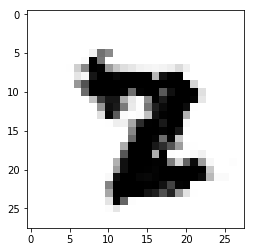

9920
d_loss_real:
22.1658
d_loss_fake:
337.93
9940
d_loss_real:
28.7694
d_loss_fake:
343.208
9960
d_loss_real:
21.8855
d_loss_fake:
281.309
9980
d_loss_real:
42.3119
d_loss_fake:
316.546
10000
d_loss_real:
43.8017
d_loss_fake:
306.035


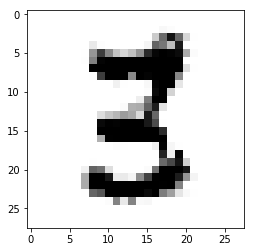

10020
d_loss_real:
15.555
d_loss_fake:
333.644
10040
d_loss_real:
32.3571
d_loss_fake:
311.098
10060
d_loss_real:
32.4462
d_loss_fake:
311.846
10080
d_loss_real:
36.0823
d_loss_fake:
113.742
10100
d_loss_real:
23.2133
d_loss_fake:
324.441


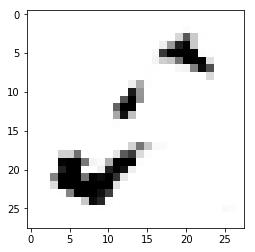

10120
d_loss_real:
26.9666
d_loss_fake:
316.621
10140
d_loss_real:
28.7343
d_loss_fake:
308.258
10160
d_loss_real:
18.62
d_loss_fake:
319.422
10180
d_loss_real:
41.4341
d_loss_fake:
294.593
10200
d_loss_real:
19.1715
d_loss_fake:
285.54


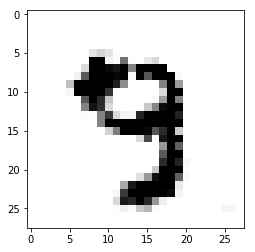

10220
d_loss_real:
30.3056
d_loss_fake:
292.733
10240
d_loss_real:
29.7391
d_loss_fake:
278.621
10260
d_loss_real:
17.6303
d_loss_fake:
299.357
10280
d_loss_real:
18.8914
d_loss_fake:
277.442
10300
d_loss_real:
17.4729
d_loss_fake:
269.02


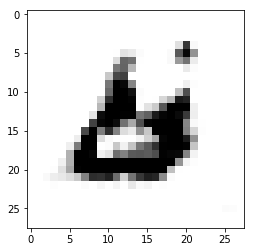

10320
d_loss_real:
27.3809
d_loss_fake:
266.88
10340
d_loss_real:
31.3098
d_loss_fake:
269.793
10360
d_loss_real:
30.7516
d_loss_fake:
268.378
10380
d_loss_real:
32.685
d_loss_fake:
250.772
10400
d_loss_real:
27.3308
d_loss_fake:
273.616


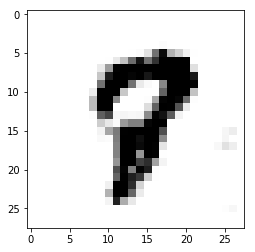

10420
d_loss_real:
24.0392
d_loss_fake:
240.946
10440
d_loss_real:
18.6349
d_loss_fake:
248.898
10460
d_loss_real:
20.402
d_loss_fake:
262.583
10480
d_loss_real:
26.1955
d_loss_fake:
254.083
10500
d_loss_real:
22.0146
d_loss_fake:
266.232


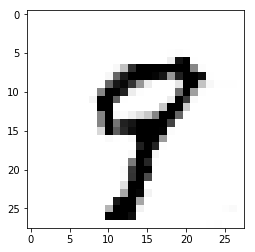

10520
d_loss_real:
32.2681
d_loss_fake:
226.026
10540
d_loss_real:
27.9549
d_loss_fake:
98.3635
10560
d_loss_real:
27.2103
d_loss_fake:
83.6532
10580
d_loss_real:
29.6571
d_loss_fake:
230.482
10600
d_loss_real:
43.4693
d_loss_fake:
307.274


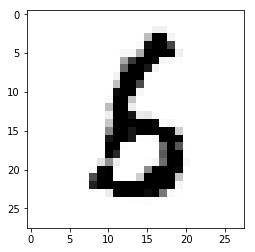

10620
d_loss_real:
31.5471
d_loss_fake:
222.024
10640
d_loss_real:
68.6668
d_loss_fake:
203.958
10660
d_loss_real:
50.7232
d_loss_fake:
277.723
10680
d_loss_real:
66.1793
d_loss_fake:
310.131
10700
d_loss_real:
41.1864
d_loss_fake:
127.611


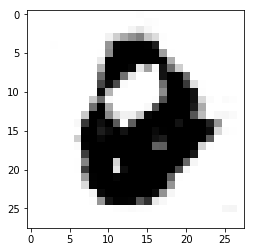

10720
d_loss_real:
57.5107
d_loss_fake:
206.857
10740
d_loss_real:
44.1101
d_loss_fake:
202.084
10760
d_loss_real:
68.7059
d_loss_fake:
219.211
10780
d_loss_real:
31.6633
d_loss_fake:
214.126
10800
d_loss_real:
53.0223
d_loss_fake:
177.496


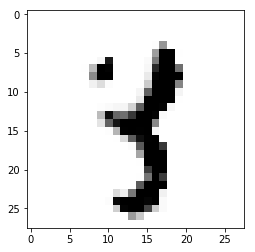

10820
d_loss_real:
45.2405
d_loss_fake:
250.676
10840
d_loss_real:
49.6232
d_loss_fake:
237.604
10860
d_loss_real:
42.1964
d_loss_fake:
274.684
10880
d_loss_real:
48.4405
d_loss_fake:
151.158
10900
d_loss_real:
37.8016
d_loss_fake:
201.741


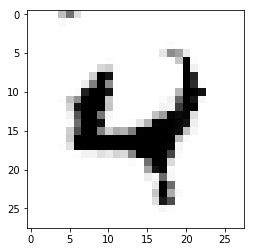

10920
d_loss_real:
21.7044
d_loss_fake:
269.152
10940
d_loss_real:
27.341
d_loss_fake:
29.1488
10960
d_loss_real:
26.4942
d_loss_fake:
211.436
10980
d_loss_real:
46.7072
d_loss_fake:
163.687
11000
d_loss_real:
33.0777
d_loss_fake:
230.202


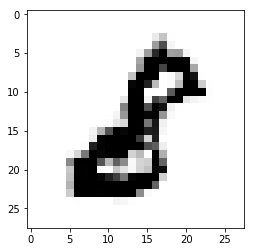

11020
d_loss_real:
72.6507
d_loss_fake:
229.347
11040
d_loss_real:
30.4414
d_loss_fake:
179.57
11060
d_loss_real:
60.0629
d_loss_fake:
176.52
11080
d_loss_real:
48.7656
d_loss_fake:
236.507
11100
d_loss_real:
83.1669
d_loss_fake:
231.546


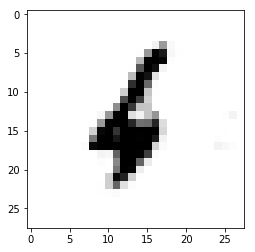

11120
d_loss_real:
44.4238
d_loss_fake:
158.153
11140
d_loss_real:
62.5684
d_loss_fake:
206.466
11160
d_loss_real:
26.42
d_loss_fake:
247.317
11180
d_loss_real:
62.6216
d_loss_fake:
301.323
11200
d_loss_real:
39.5281
d_loss_fake:
154.64


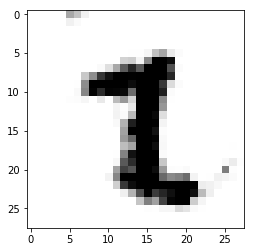

11220
d_loss_real:
62.89
d_loss_fake:
160.258
11240
d_loss_real:
51.2637
d_loss_fake:
198.611
11260
d_loss_real:
34.122
d_loss_fake:
310.284
11280
d_loss_real:
22.996
d_loss_fake:
233.611
11300
d_loss_real:
58.3529
d_loss_fake:
154.828


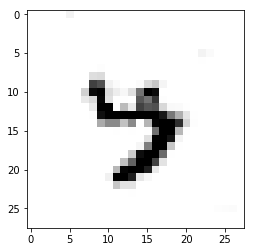

11320
d_loss_real:
62.8714
d_loss_fake:
207.263
11340
d_loss_real:
67.0234
d_loss_fake:
174.791
11360
d_loss_real:
27.9106
d_loss_fake:
113.559
11380
d_loss_real:
43.283
d_loss_fake:
107.767
11400
d_loss_real:
22.7054
d_loss_fake:
199.021


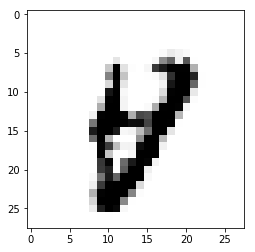

11420
d_loss_real:
22.9686
d_loss_fake:
242.256
11440
d_loss_real:
24.0534
d_loss_fake:
288.445
11460
d_loss_real:
37.8079
d_loss_fake:
190.172
11480
d_loss_real:
38.8214
d_loss_fake:
207.297
11500
d_loss_real:
47.9315
d_loss_fake:
177.076


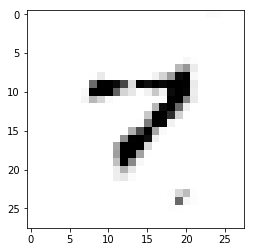

11520
d_loss_real:
35.3479
d_loss_fake:
224.753
11540
d_loss_real:
29.8772
d_loss_fake:
218.696
11560
d_loss_real:
37.239
d_loss_fake:
201.037
11580
d_loss_real:
44.4284
d_loss_fake:
199.193
11600
d_loss_real:
32.0364
d_loss_fake:
239.603


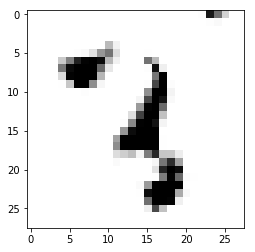

11620
d_loss_real:
30.9807
d_loss_fake:
221.991
11640
d_loss_real:
30.3334
d_loss_fake:
207.459
11660
d_loss_real:
38.8974
d_loss_fake:
220.299
11680
d_loss_real:
37.8785
d_loss_fake:
206.633
11700
d_loss_real:
29.2233
d_loss_fake:
223.251


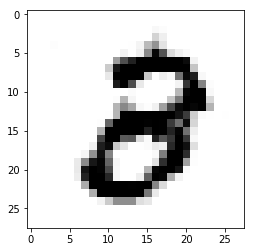

11720
d_loss_real:
52.503
d_loss_fake:
199.013
11740
d_loss_real:
44.5198
d_loss_fake:
207.125
11760
d_loss_real:
48.9147
d_loss_fake:
188.446
11780
d_loss_real:
54.9181
d_loss_fake:
239.603
11800
d_loss_real:
50.3503
d_loss_fake:
225.476


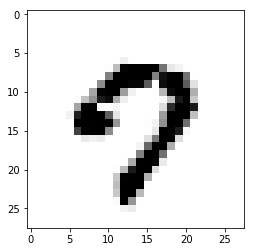

11820
d_loss_real:
27.6375
d_loss_fake:
205.662
11840
d_loss_real:
10.9308
d_loss_fake:
151.226
11860
d_loss_real:
46.641
d_loss_fake:
207.137
11880
d_loss_real:
44.5707
d_loss_fake:
194.344
11900
d_loss_real:
40.6587
d_loss_fake:
199.99


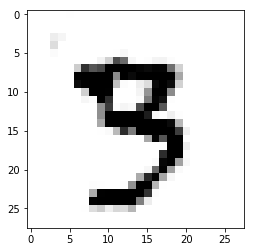

11920
d_loss_real:
86.0821
d_loss_fake:
151.442
11940
d_loss_real:
35.2613
d_loss_fake:
255.739
11960
d_loss_real:
42.3485
d_loss_fake:
145.435
11980
d_loss_real:
43.3936
d_loss_fake:
254.61
12000
d_loss_real:
88.075
d_loss_fake:
92.5024


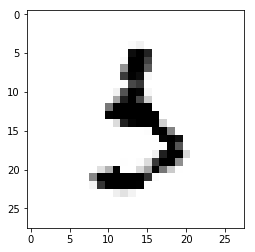

12020
d_loss_real:
35.9403
d_loss_fake:
130.824
12040
d_loss_real:
27.9484
d_loss_fake:
155.146
12060
d_loss_real:
44.066
d_loss_fake:
192.516
12080
d_loss_real:
25.0829
d_loss_fake:
227.696
12100
d_loss_real:
53.2999
d_loss_fake:
178.985


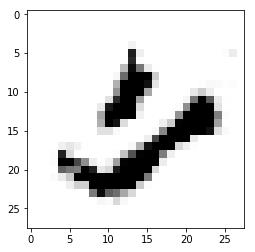

12120
d_loss_real:
14.5554
d_loss_fake:
303.451
12140
d_loss_real:
62.4093
d_loss_fake:
293.825
12160
d_loss_real:
49.1573
d_loss_fake:
166.383
12180
d_loss_real:
64.3296
d_loss_fake:
168.46
12200
d_loss_real:
64.6641
d_loss_fake:
176.733


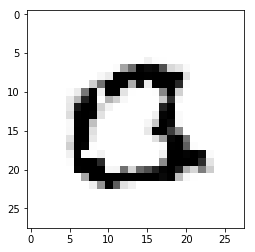

12220
d_loss_real:
16.6931
d_loss_fake:
376.132
12240
d_loss_real:
37.5329
d_loss_fake:
154.295
12260
d_loss_real:
73.6441
d_loss_fake:
166.806
12280
d_loss_real:
68.3089
d_loss_fake:
190.961
12300
d_loss_real:
28.8507
d_loss_fake:
343.622


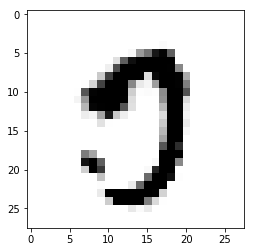

12320
d_loss_real:
18.7548
d_loss_fake:
155.572
12340
d_loss_real:
32.5808
d_loss_fake:
204.808
12360
d_loss_real:
47.7865
d_loss_fake:
9.79601
12380
d_loss_real:
99.1065
d_loss_fake:
263.923
12400
d_loss_real:
43.1836
d_loss_fake:
5.28082


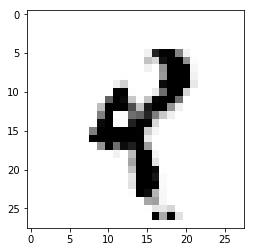

12420
d_loss_real:
64.633
d_loss_fake:
80.7142
12440
d_loss_real:
51.0257
d_loss_fake:
193.806
12460
d_loss_real:
67.8164
d_loss_fake:
277.643
12480
d_loss_real:
54.5462
d_loss_fake:
245.65
12500
d_loss_real:
36.5525
d_loss_fake:
178.352


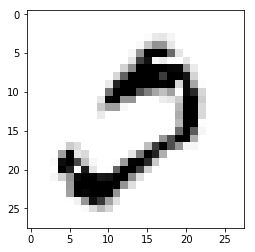

12520
d_loss_real:
62.032
d_loss_fake:
132.417
12540
d_loss_real:
93.2467
d_loss_fake:
260.079
12560
d_loss_real:
37.6593
d_loss_fake:
233.389
12580
d_loss_real:
60.3721
d_loss_fake:
146.114
12600
d_loss_real:
46.779
d_loss_fake:
193.09


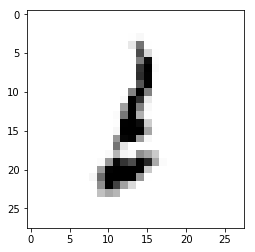

12620
d_loss_real:
42.9372
d_loss_fake:
236.572
12640
d_loss_real:
37.8594
d_loss_fake:
268.749
12660
d_loss_real:
32.8851
d_loss_fake:
168.984
12680
d_loss_real:
35.8554
d_loss_fake:
177.76
12700
d_loss_real:
23.1184
d_loss_fake:
286.4


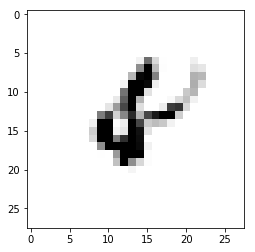

12720
d_loss_real:
32.1317
d_loss_fake:
277.569
12740
d_loss_real:
48.6753
d_loss_fake:
174.771
12760
d_loss_real:
54.0774
d_loss_fake:
213.491
12780
d_loss_real:
52.419
d_loss_fake:
260.535
12800
d_loss_real:
45.2174
d_loss_fake:
275.043


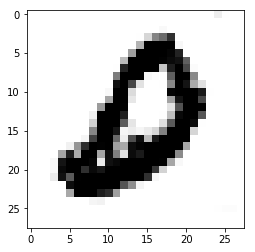

12820
d_loss_real:
51.2364
d_loss_fake:
155.138
12840
d_loss_real:
31.7828
d_loss_fake:
256.163
12860
d_loss_real:
56.6382
d_loss_fake:
285.332
12880
d_loss_real:
52.1558
d_loss_fake:
232.974
12900
d_loss_real:
43.1846
d_loss_fake:
182.134


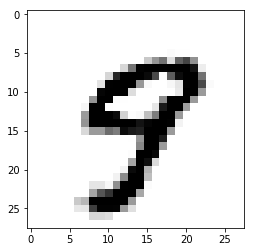

12920
d_loss_real:
48.8242
d_loss_fake:
241.448
12940
d_loss_real:
86.9725
d_loss_fake:
23.6905
12960
d_loss_real:
45.127
d_loss_fake:
383.019
12980
d_loss_real:
25.9241
d_loss_fake:
218.083
13000
d_loss_real:
29.3416
d_loss_fake:
309.505


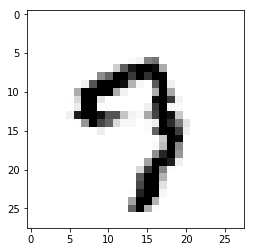

13020
d_loss_real:
69.1784
d_loss_fake:
289.804
13040
d_loss_real:
27.9639
d_loss_fake:
243.531
13060
d_loss_real:
48.6797
d_loss_fake:
199.963
13080
d_loss_real:
45.7949
d_loss_fake:
287.087
13100
d_loss_real:
108.04
d_loss_fake:
306.536


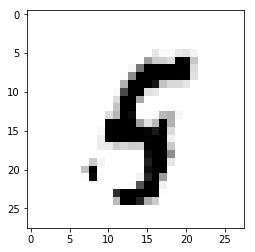

13120
d_loss_real:
53.9477
d_loss_fake:
160.983
13140
d_loss_real:
52.049
d_loss_fake:
157.806
13160
d_loss_real:
61.2804
d_loss_fake:
226.068
13180
d_loss_real:
65.8745
d_loss_fake:
305.039
13200
d_loss_real:
60.9949
d_loss_fake:
200.853


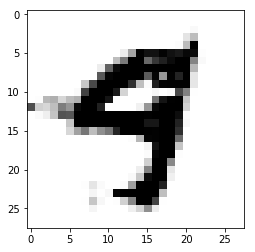

13220
d_loss_real:
60.8867
d_loss_fake:
199.701
13240
d_loss_real:
39.9982
d_loss_fake:
249.665
13260
d_loss_real:
53.3849
d_loss_fake:
321.046
13280
d_loss_real:
45.3024
d_loss_fake:
192.375
13300
d_loss_real:
58.0888
d_loss_fake:
173.248


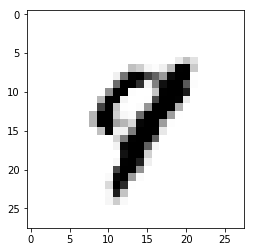

13320
d_loss_real:
29.5704
d_loss_fake:
269.191
13340
d_loss_real:
57.448
d_loss_fake:
294.112
13360
d_loss_real:
52.0461
d_loss_fake:
182.876
13380
d_loss_real:
64.8539
d_loss_fake:
52.2421
13400
d_loss_real:
117.017
d_loss_fake:
150.32


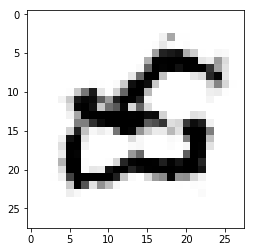

13420
d_loss_real:
21.5171
d_loss_fake:
354.716
13440
d_loss_real:
28.8166
d_loss_fake:
226.074
13460
d_loss_real:
52.6593
d_loss_fake:
183.018
13480
d_loss_real:
49.2453
d_loss_fake:
259.044
13500
d_loss_real:
54.5144
d_loss_fake:
279.787


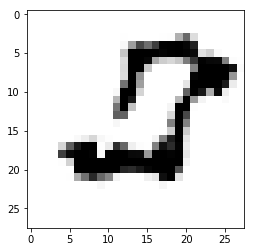

13520
d_loss_real:
42.7102
d_loss_fake:
255.461
13540
d_loss_real:
49.4172
d_loss_fake:
233.999
13560
d_loss_real:
34.9913
d_loss_fake:
263.984
13580
d_loss_real:
76.9646
d_loss_fake:
281.009
13600
d_loss_real:
47.084
d_loss_fake:
238.297


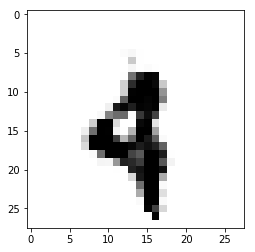

13620
d_loss_real:
67.4069
d_loss_fake:
204.825
13640
d_loss_real:
40.0768
d_loss_fake:
263.627
13660
d_loss_real:
62.7089
d_loss_fake:
275.515
13680
d_loss_real:
26.4066
d_loss_fake:
235.685
13700
d_loss_real:
34.1874
d_loss_fake:
234.937


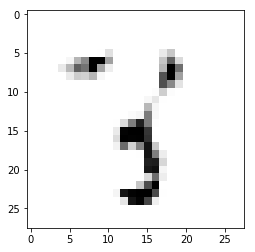

13720
d_loss_real:
23.5768
d_loss_fake:
274.878
13740
d_loss_real:
36.4627
d_loss_fake:
309.167
13760
d_loss_real:
42.8935
d_loss_fake:
245.327
13780
d_loss_real:
39.9106
d_loss_fake:
215.083
13800
d_loss_real:
60.1905
d_loss_fake:
240.535


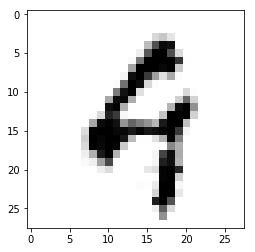

13820
d_loss_real:
36.2894
d_loss_fake:
123.62
13840
d_loss_real:
61.0757
d_loss_fake:
175.306
13860
d_loss_real:
50.4263
d_loss_fake:
207.455
13880
d_loss_real:
50.0074
d_loss_fake:
232.715
13900
d_loss_real:
53.2655
d_loss_fake:
290.307


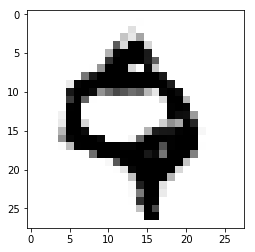

13920
d_loss_real:
54.3851
d_loss_fake:
190.357
13940
d_loss_real:
49.1753
d_loss_fake:
268.983
13960
d_loss_real:
69.3427
d_loss_fake:
260.128
13980
d_loss_real:
47.9423
d_loss_fake:
260.775
14000
d_loss_real:
67.4493
d_loss_fake:
190.3


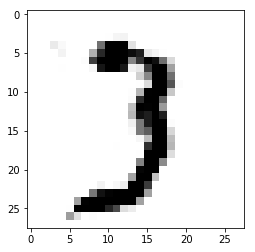

14020
d_loss_real:
47.5241
d_loss_fake:
12.0367
14040
d_loss_real:
98.0653
d_loss_fake:
203.791
14060
d_loss_real:
46.859
d_loss_fake:
218.212
14080
d_loss_real:
47.8596
d_loss_fake:
225.273
14100
d_loss_real:
33.864
d_loss_fake:
282.193


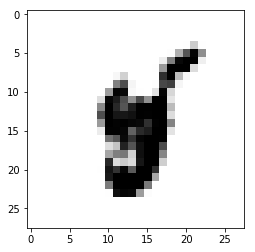

14120
d_loss_real:
91.0518
d_loss_fake:
292.497
14140
d_loss_real:
46.3205
d_loss_fake:
183.034
14160
d_loss_real:
61.9225
d_loss_fake:
213.621
14180
d_loss_real:
58.8603
d_loss_fake:
271.143
14200
d_loss_real:
52.3446
d_loss_fake:
262.932


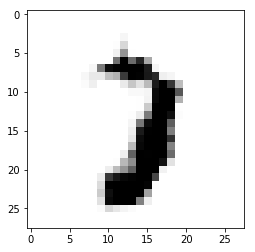

14220
d_loss_real:
56.4847
d_loss_fake:
258.838
14240
d_loss_real:
43.7539
d_loss_fake:
166.044
14260
d_loss_real:
97.776
d_loss_fake:
288.464
14280
d_loss_real:
56.1541
d_loss_fake:
263.917
14300
d_loss_real:
50.6122
d_loss_fake:
254.741


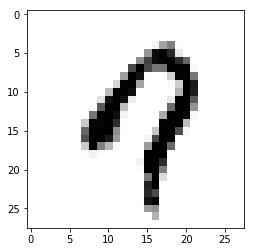

14320
d_loss_real:
17.1997
d_loss_fake:
289.128
14340
d_loss_real:
45.7461
d_loss_fake:
233.438
14360
d_loss_real:
34.091
d_loss_fake:
210.639
14380
d_loss_real:
41.2575
d_loss_fake:
266.32
14400
d_loss_real:
66.0549
d_loss_fake:
257.457


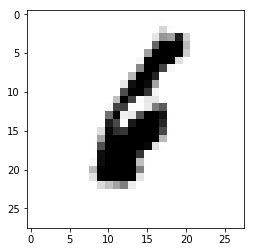

14420
d_loss_real:
85.6371
d_loss_fake:
240.848
14440
d_loss_real:
39.6813
d_loss_fake:
266.756
14460
d_loss_real:
29.1003
d_loss_fake:
261.614
14480
d_loss_real:
29.0623
d_loss_fake:
305.218
14500
d_loss_real:
43.6704
d_loss_fake:
282.765


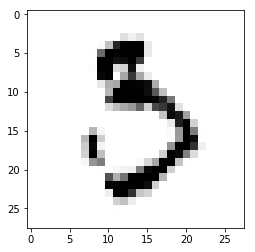

14520
d_loss_real:
33.2241
d_loss_fake:
294.266
14540
d_loss_real:
18.72
d_loss_fake:
252.027
14560
d_loss_real:
53.8771
d_loss_fake:
264.644
14580
d_loss_real:
113.379
d_loss_fake:
235.415
14600
d_loss_real:
67.8578
d_loss_fake:
190.576


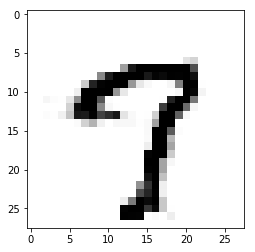

14620
d_loss_real:
67.6691
d_loss_fake:
134.745
14640
d_loss_real:
62.8171
d_loss_fake:
232.902
14660
d_loss_real:
27.7367
d_loss_fake:
296.103
14680
d_loss_real:
66.7513
d_loss_fake:
224.657
14700
d_loss_real:
42.843
d_loss_fake:
214.014


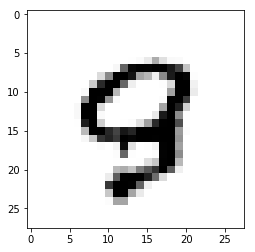

14720
d_loss_real:
72.3217
d_loss_fake:
287.445
14740
d_loss_real:
69.0717
d_loss_fake:
148.457
14760
d_loss_real:
62.1713
d_loss_fake:
80.9276
14780
d_loss_real:
130.136
d_loss_fake:
148.787
14800
d_loss_real:
55.1904
d_loss_fake:
225.29


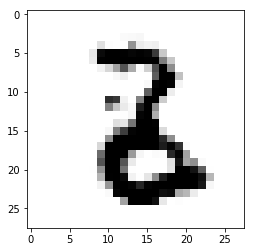

14820
d_loss_real:
56.6565
d_loss_fake:
179.556
14840
d_loss_real:
38.1681
d_loss_fake:
341.801
14860
d_loss_real:
78.4652
d_loss_fake:
219.182
14880
d_loss_real:
54.7133
d_loss_fake:
214.258
14900
d_loss_real:
72.4059
d_loss_fake:
218.801


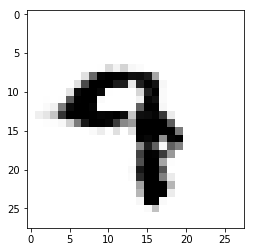

14920
d_loss_real:
63.5399
d_loss_fake:
245.019
14940
d_loss_real:
41.4647
d_loss_fake:
289.025
14960
d_loss_real:
35.467
d_loss_fake:
216.944
14980
d_loss_real:
68.9896
d_loss_fake:
223.687
15000
d_loss_real:
60.3417
d_loss_fake:
344.541


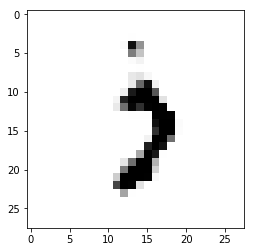

15020
d_loss_real:
69.8354
d_loss_fake:
181.303
15040
d_loss_real:
49.8997
d_loss_fake:
235.747
15060
d_loss_real:
47.2713
d_loss_fake:
231.92
15080
d_loss_real:
28.923
d_loss_fake:
279.897
15100
d_loss_real:
39.0138
d_loss_fake:
243.764


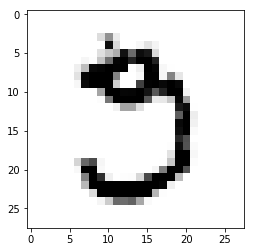

15120
d_loss_real:
14.1398
d_loss_fake:
276.135
15140
d_loss_real:
31.2054
d_loss_fake:
290.242
15160
d_loss_real:
35.599
d_loss_fake:
260.702
15180
d_loss_real:
70.2849
d_loss_fake:
46.4694
15200
d_loss_real:
74.6711
d_loss_fake:
183.051


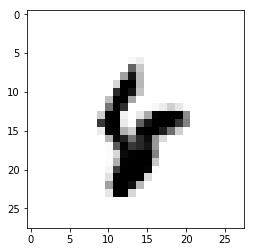

15220
d_loss_real:
63.496
d_loss_fake:
235.583
15240
d_loss_real:
65.9286
d_loss_fake:
214.288
15260
d_loss_real:
50.2514
d_loss_fake:
245.938
15280
d_loss_real:
53.8752
d_loss_fake:
295.488
15300
d_loss_real:
36.6757
d_loss_fake:
235.744


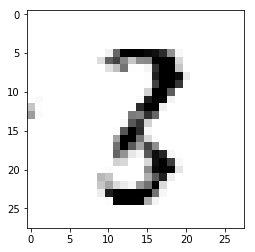

15320
d_loss_real:
66.7119
d_loss_fake:
209.123
15340
d_loss_real:
65.7032
d_loss_fake:
234.63
15360
d_loss_real:
55.5292
d_loss_fake:
328.476
15380
d_loss_real:
67.2489
d_loss_fake:
190.28
15400
d_loss_real:
70.9767
d_loss_fake:
248.379


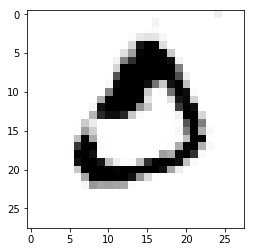

15420
d_loss_real:
63.4885
d_loss_fake:
243.087
15440
d_loss_real:
38.1996
d_loss_fake:
246.484
15460
d_loss_real:
39.832
d_loss_fake:
216.35
15480
d_loss_real:
46.0192
d_loss_fake:
247.406
15500
d_loss_real:
53.9543
d_loss_fake:
224.495


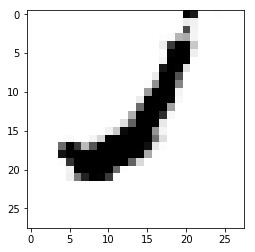

15520
d_loss_real:
44.5458
d_loss_fake:
306.755
15540
d_loss_real:
38.2523
d_loss_fake:
245.674
15560
d_loss_real:
80.5629
d_loss_fake:
183.664
15580
d_loss_real:
84.0327
d_loss_fake:
44.8964
15600
d_loss_real:
47.4496
d_loss_fake:
245.761


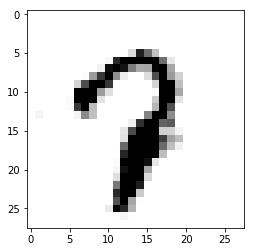

15620
d_loss_real:
97.49
d_loss_fake:
171.254
15640
d_loss_real:
74.1299
d_loss_fake:
187.736
15660
d_loss_real:
58.2447
d_loss_fake:
249.618
15680
d_loss_real:
35.3232
d_loss_fake:
298.334
15700
d_loss_real:
62.4849
d_loss_fake:
201.632


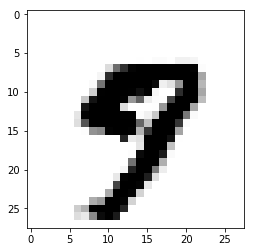

15720
d_loss_real:
87.2983
d_loss_fake:
202.011
15740
d_loss_real:
80.1165
d_loss_fake:
227.066
15760
d_loss_real:
45.83
d_loss_fake:
252.633
15780
d_loss_real:
57.4004
d_loss_fake:
165.847
15800
d_loss_real:
78.7396
d_loss_fake:
207.466


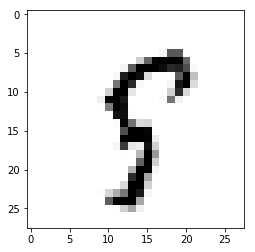

15820
d_loss_real:
56.2874
d_loss_fake:
214.862
15840
d_loss_real:
55.3276
d_loss_fake:
231.939
15860
d_loss_real:
60.6416
d_loss_fake:
207.205
15880
d_loss_real:
58.403
d_loss_fake:
214.734
15900
d_loss_real:
89.3799
d_loss_fake:
207.761


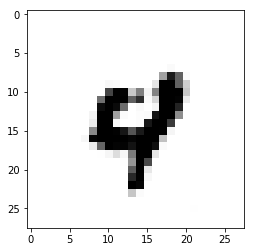

15920
d_loss_real:
49.5624
d_loss_fake:
179.156
15940
d_loss_real:
71.285
d_loss_fake:
244.874
15960
d_loss_real:
104.537
d_loss_fake:
212.119
15980
d_loss_real:
86.8215
d_loss_fake:
172.128
16000
d_loss_real:
67.805
d_loss_fake:
27.9895


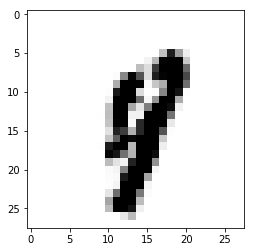

16020
d_loss_real:
106.144
d_loss_fake:
190.038
16040
d_loss_real:
64.3776
d_loss_fake:
258.039
16060
d_loss_real:
66.079
d_loss_fake:
232.596
16080
d_loss_real:
47.7776
d_loss_fake:
231.172
16100
d_loss_real:
47.7666
d_loss_fake:
283.032


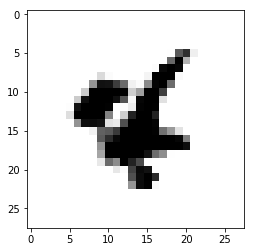

16120
d_loss_real:
26.0349
d_loss_fake:
282.483
16140
d_loss_real:
63.1281
d_loss_fake:
270.521
16160
d_loss_real:
42.1691
d_loss_fake:
82.6591
16180
d_loss_real:
67.0624
d_loss_fake:
242.344
16200
d_loss_real:
102.567
d_loss_fake:
217.771


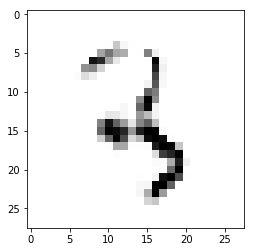

16220
d_loss_real:
107.526
d_loss_fake:
139.797
16240
d_loss_real:
79.6896
d_loss_fake:
216.805
16260
d_loss_real:
62.3495
d_loss_fake:
285.248
16280
d_loss_real:
136.354
d_loss_fake:
218.66
16300
d_loss_real:
78.7649
d_loss_fake:
204.397


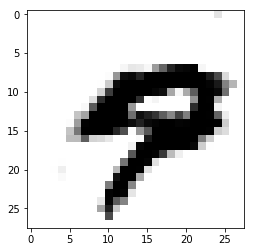

16320
d_loss_real:
71.528
d_loss_fake:
228.613
16340
d_loss_real:
87.7832
d_loss_fake:
179.62
16360
d_loss_real:
94.6522
d_loss_fake:
292.284
16380
d_loss_real:
74.1425
d_loss_fake:
183.621
16400
d_loss_real:
63.0355
d_loss_fake:
289.878


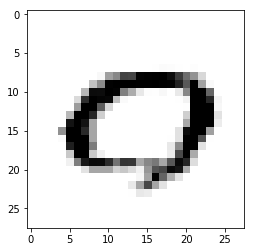

16420
d_loss_real:
102.209
d_loss_fake:
266.482
16440
d_loss_real:
30.8576
d_loss_fake:
294.624
16460
d_loss_real:
93.9188
d_loss_fake:
220.185
16480
d_loss_real:
94.9543
d_loss_fake:
213.219
16500
d_loss_real:
98.6232
d_loss_fake:
228.403


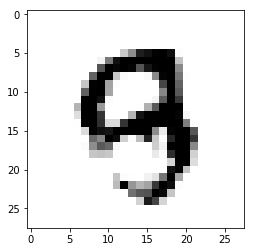

16520
d_loss_real:
75.5297
d_loss_fake:
230.986
16540
d_loss_real:
42.5275
d_loss_fake:
155.355
16560
d_loss_real:
118.259
d_loss_fake:
216.796
16580
d_loss_real:
78.271
d_loss_fake:
301.447
16600
d_loss_real:
113.947
d_loss_fake:
204.531


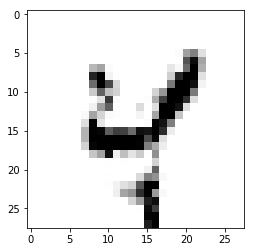

16620
d_loss_real:
84.1625
d_loss_fake:
215.69
16640
d_loss_real:
88.4868
d_loss_fake:
280.355
16660
d_loss_real:
112.897
d_loss_fake:
21.3278
16680
d_loss_real:
71.7299
d_loss_fake:
261.425
16700
d_loss_real:
94.32
d_loss_fake:
296.932


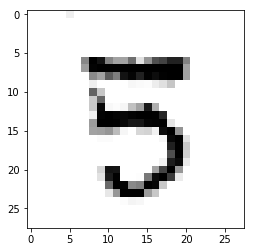

16720
d_loss_real:
82.07
d_loss_fake:
145.196
16740
d_loss_real:
92.6815
d_loss_fake:
248.779
16760
d_loss_real:
66.7484
d_loss_fake:
277.151
16780
d_loss_real:
85.0332
d_loss_fake:
335.937
16800
d_loss_real:
116.885
d_loss_fake:
230.045


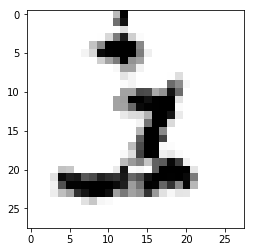

16820
d_loss_real:
67.2771
d_loss_fake:
228.133
16840
d_loss_real:
172.627
d_loss_fake:
304.149
16860
d_loss_real:
34.4468
d_loss_fake:
208.236
16880
d_loss_real:
91.2018
d_loss_fake:
131.52
16900
d_loss_real:
46.2133
d_loss_fake:
305.905


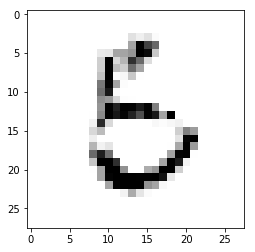

16920
d_loss_real:
121.594
d_loss_fake:
388.794
16940
d_loss_real:
100.584
d_loss_fake:
190.466
16960
d_loss_real:
92.2342
d_loss_fake:
265.185
16980
d_loss_real:
74.7411
d_loss_fake:
268.926
17000
d_loss_real:
102.417
d_loss_fake:
259.894


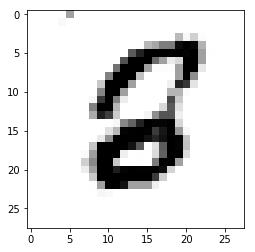

17020
d_loss_real:
115.415
d_loss_fake:
189.21
17040
d_loss_real:
200.498
d_loss_fake:
232.827
17060
d_loss_real:
154.49
d_loss_fake:
232.66
17080
d_loss_real:
116.312
d_loss_fake:
28.3265
17100
d_loss_real:
95.4718
d_loss_fake:
109.86


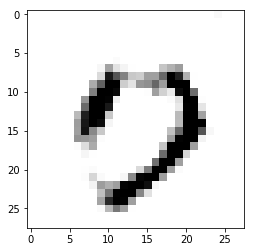

17120
d_loss_real:
93.3449
d_loss_fake:
121.388
17140
d_loss_real:
155.217
d_loss_fake:
289.335
17160
d_loss_real:
157.174
d_loss_fake:
317.02
17180
d_loss_real:
243.518
d_loss_fake:
408.997
17200
d_loss_real:
132.524
d_loss_fake:
161.93


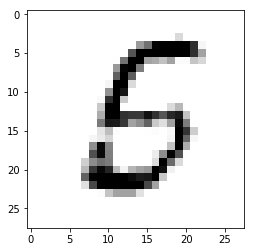

17220
d_loss_real:
229.227
d_loss_fake:
465.832
17240
d_loss_real:
119.562
d_loss_fake:
172.243
17260
d_loss_real:
102.74
d_loss_fake:
544.749
17280
d_loss_real:
159.794
d_loss_fake:
231.321
17300
d_loss_real:
235.581
d_loss_fake:
657.694


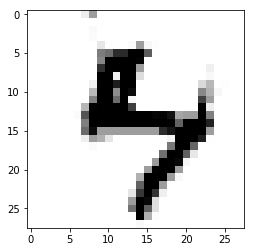

17320
d_loss_real:
82.5085
d_loss_fake:
698.065
17340
d_loss_real:
137.135
d_loss_fake:
48.5679
17360
d_loss_real:
148.97
d_loss_fake:
368.838
17380
d_loss_real:
189.851
d_loss_fake:
648.584
17400
d_loss_real:
371.827
d_loss_fake:
373.775


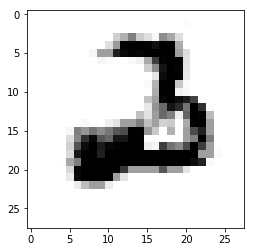

17420
d_loss_real:
175.874
d_loss_fake:
421.753
17440
d_loss_real:
278.138
d_loss_fake:
469.561
17460
d_loss_real:
184.097
d_loss_fake:
584.805
17480
d_loss_real:
179.03
d_loss_fake:
686.9
17500
d_loss_real:
96.3294
d_loss_fake:
509.72


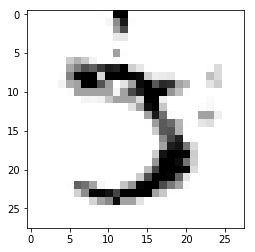

17520
d_loss_real:
186.311
d_loss_fake:
568.52
17540
d_loss_real:
179.981
d_loss_fake:
433.869
17560
d_loss_real:
226.995
d_loss_fake:
627.954
17580
d_loss_real:
107.321
d_loss_fake:
265.793
17600
d_loss_real:
171.373
d_loss_fake:
614.674


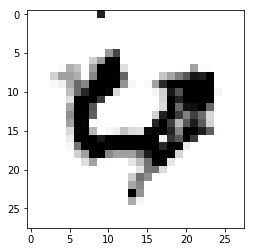

17620
d_loss_real:
120.464
d_loss_fake:
787.979
17640
d_loss_real:
209.194
d_loss_fake:
491.28
17660
d_loss_real:
65.364
d_loss_fake:
742.272
17680
d_loss_real:
157.28
d_loss_fake:
543.603
17700
d_loss_real:
187.123
d_loss_fake:
643.184


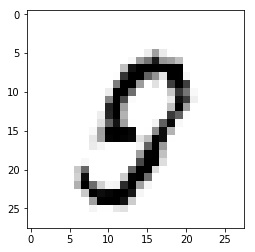

17720
d_loss_real:
114.316
d_loss_fake:
564.308
17740
d_loss_real:
214.721
d_loss_fake:
733.372
17760
d_loss_real:
116.6
d_loss_fake:
826.728
17780
d_loss_real:
145.734
d_loss_fake:
749.168
17800
d_loss_real:
186.858
d_loss_fake:
768.314


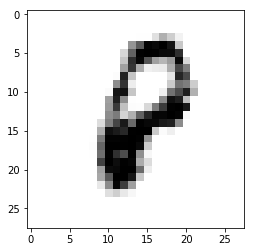

17820
d_loss_real:
180.514
d_loss_fake:
610.95
17840
d_loss_real:
124.408
d_loss_fake:
702.604
17860
d_loss_real:
83.4061
d_loss_fake:
797.51
17880
d_loss_real:
169.754
d_loss_fake:
881.875
17900
d_loss_real:
123.266
d_loss_fake:
884.168


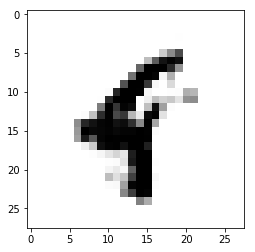

17920
d_loss_real:
176.269
d_loss_fake:
675.996
17940
d_loss_real:
145.457
d_loss_fake:
1241.18
17960
d_loss_real:
226.088
d_loss_fake:
681.107
17980
d_loss_real:
115.274
d_loss_fake:
689.218
18000
d_loss_real:
190.842
d_loss_fake:
738.31


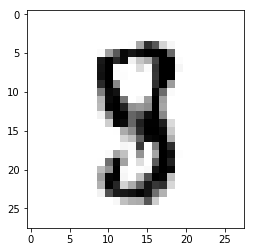

18020
d_loss_real:
313.395
d_loss_fake:
278.442
18040
d_loss_real:
162.071
d_loss_fake:
1055.97
18060
d_loss_real:
42.0395
d_loss_fake:
998.736
18080
d_loss_real:
52.581
d_loss_fake:
953.708
18100
d_loss_real:
94.218
d_loss_fake:
640.423


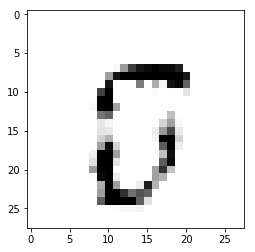

18120
d_loss_real:
205.659
d_loss_fake:
797.298
18140
d_loss_real:
323.678
d_loss_fake:
684.24
18160
d_loss_real:
247.605
d_loss_fake:
464.93
18180
d_loss_real:
301.373
d_loss_fake:
713.373
18200
d_loss_real:
425.463
d_loss_fake:
459.614


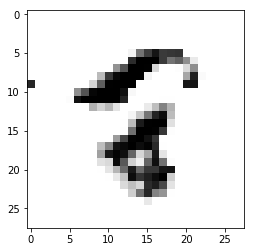

18220
d_loss_real:
232.131
d_loss_fake:
472.712
18240
d_loss_real:
319.673
d_loss_fake:
472.278
18260
d_loss_real:
377.382
d_loss_fake:
633.504
18280
d_loss_real:
166.593
d_loss_fake:
420.171
18300
d_loss_real:
234.837
d_loss_fake:
537.241


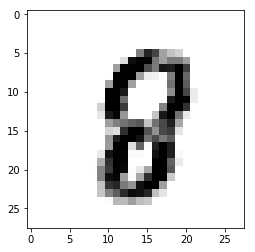

18320
d_loss_real:
164.342
d_loss_fake:
95.6317
18340
d_loss_real:
169.502
d_loss_fake:
496.013
18360
d_loss_real:
248.748
d_loss_fake:
268.478
18380
d_loss_real:
309.566
d_loss_fake:
717.603
18400
d_loss_real:
310.53
d_loss_fake:
526.252


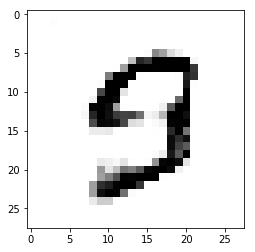

18420
d_loss_real:
194.905
d_loss_fake:
653.309
18440
d_loss_real:
301.776
d_loss_fake:
495.173
18460
d_loss_real:
246.892
d_loss_fake:
815.035
18480
d_loss_real:
188.645
d_loss_fake:
818.985
18500
d_loss_real:
343.669
d_loss_fake:
545.486


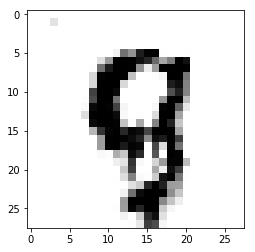

18520
d_loss_real:
341.405
d_loss_fake:
35.4388
18540
d_loss_real:
289.28
d_loss_fake:
512.15
18560
d_loss_real:
154.548
d_loss_fake:
854.245
18580
d_loss_real:
251.054
d_loss_fake:
656.736
18600
d_loss_real:
221.876
d_loss_fake:
125.528


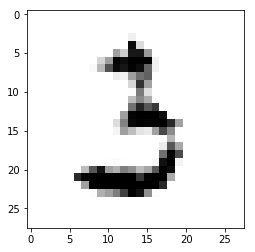

18620
d_loss_real:
152.307
d_loss_fake:
655.111
18640
d_loss_real:
211.213
d_loss_fake:
671.264
18660
d_loss_real:
243.796
d_loss_fake:
795.668
18680
d_loss_real:
204.77
d_loss_fake:
716.809
18700
d_loss_real:
228.707
d_loss_fake:
723.705


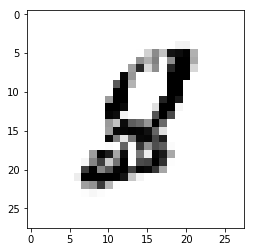

18720
d_loss_real:
342.51
d_loss_fake:
656.298
18740
d_loss_real:
190.522
d_loss_fake:
1673.12
18760
d_loss_real:
164.057
d_loss_fake:
710.376
18780
d_loss_real:
111.14
d_loss_fake:
736.882
18800
d_loss_real:
360.742
d_loss_fake:
765.727


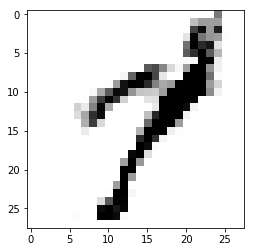

18820
d_loss_real:
168.069
d_loss_fake:
767.907
18840
d_loss_real:
248.769
d_loss_fake:
553.856
18860
d_loss_real:
268.276
d_loss_fake:
759.401
18880
d_loss_real:
237.327
d_loss_fake:
960.326
18900
d_loss_real:
273.445
d_loss_fake:
683.799


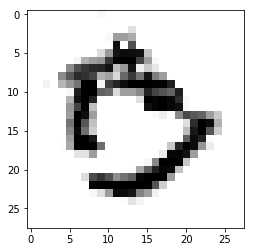

18920
d_loss_real:
422.068
d_loss_fake:
728.945
18940
d_loss_real:
222.657
d_loss_fake:
905.435
18960
d_loss_real:
123.795
d_loss_fake:
576.978
18980
d_loss_real:
145.553
d_loss_fake:
722.16
19000
d_loss_real:
187.484
d_loss_fake:
885.405


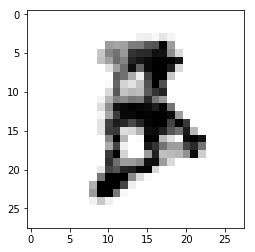

19020
d_loss_real:
122.657
d_loss_fake:
1159.01
19040
d_loss_real:
146.062
d_loss_fake:
723.839
19060
d_loss_real:
173.034
d_loss_fake:
1120.21
19080
d_loss_real:
436.545
d_loss_fake:
677.677
19100
d_loss_real:
174.967
d_loss_fake:
698.323


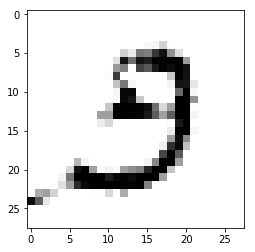

19120
d_loss_real:
269.25
d_loss_fake:
661.412
19140
d_loss_real:
225.312
d_loss_fake:
748.794
19160
d_loss_real:
325.188
d_loss_fake:
811.746
19180
d_loss_real:
266.192
d_loss_fake:
729.022
19200
d_loss_real:
263.957
d_loss_fake:
800.215


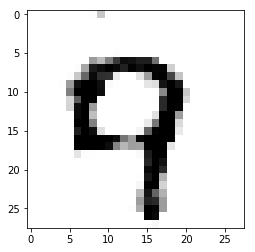

19220
d_loss_real:
237.632
d_loss_fake:
963.05
19240
d_loss_real:
284.427
d_loss_fake:
1021.47
19260
d_loss_real:
116.39
d_loss_fake:
748.48
19280
d_loss_real:
150.848
d_loss_fake:
946.396
19300
d_loss_real:
204.894
d_loss_fake:
1094.38


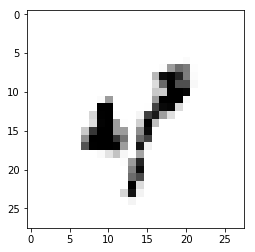

19320
d_loss_real:
126.515
d_loss_fake:
363.044
19340
d_loss_real:
168.255
d_loss_fake:
1033.79
19360
d_loss_real:
283.15
d_loss_fake:
756.77
19380
d_loss_real:
177.633
d_loss_fake:
1138.19
19400
d_loss_real:
255.336
d_loss_fake:
695.619


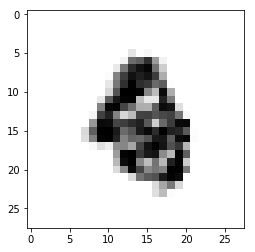

19420
d_loss_real:
164.606
d_loss_fake:
1395.94
19440
d_loss_real:
188.87
d_loss_fake:
1157.06
19460
d_loss_real:
149.297
d_loss_fake:
895.184
19480
d_loss_real:
210.862
d_loss_fake:
814.988
19500
d_loss_real:
337.471
d_loss_fake:
741.438


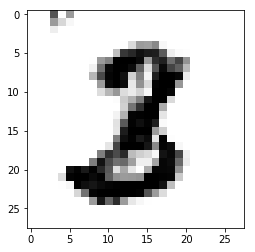

19520
d_loss_real:
175.05
d_loss_fake:
1057.35
19540
d_loss_real:
229.144
d_loss_fake:
401.941
19560
d_loss_real:
301.743
d_loss_fake:
700.162
19580
d_loss_real:
440.749
d_loss_fake:
612.593
19600
d_loss_real:
222.288
d_loss_fake:
789.515


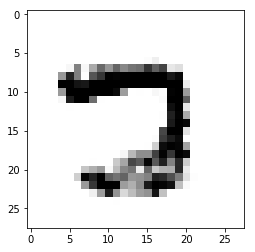

19620
d_loss_real:
279.629
d_loss_fake:
553.527
19640
d_loss_real:
337.007
d_loss_fake:
945.855
19660
d_loss_real:
211.986
d_loss_fake:
1151.53
19680
d_loss_real:
260.436
d_loss_fake:
834.133
19700
d_loss_real:
203.933
d_loss_fake:
544.332


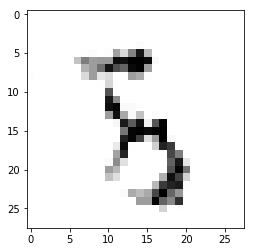

19720
d_loss_real:
245.509
d_loss_fake:
1062.52
19740
d_loss_real:
210.801
d_loss_fake:
949.212
19760
d_loss_real:
211.411
d_loss_fake:
702.017
19780
d_loss_real:
299.529
d_loss_fake:
591.523
19800
d_loss_real:
289.719
d_loss_fake:
1004.5


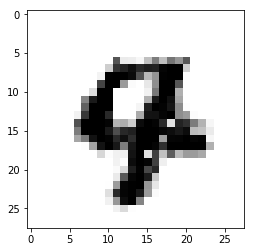

19820
d_loss_real:
425.47
d_loss_fake:
885.429
19840
d_loss_real:
250.361
d_loss_fake:
520.425
19860
d_loss_real:
236.22
d_loss_fake:
601.57
19880
d_loss_real:
166.432
d_loss_fake:
1128.34
19900
d_loss_real:
340.277
d_loss_fake:
826.067


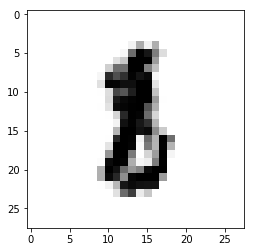

19920
d_loss_real:
176.224
d_loss_fake:
672.34
19940
d_loss_real:
276.801
d_loss_fake:
665.131
19960
d_loss_real:
288.83
d_loss_fake:
845.035
19980
d_loss_real:
335.131
d_loss_fake:
213.407
20000
d_loss_real:
251.984
d_loss_fake:
467.117


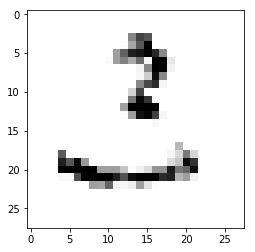

20020
d_loss_real:
237.385
d_loss_fake:
753.241
20040
d_loss_real:
244.057
d_loss_fake:
986.127
20060
d_loss_real:
199.996
d_loss_fake:
869.642
20080
d_loss_real:
132.119
d_loss_fake:
758.245
20100
d_loss_real:
301.056
d_loss_fake:
954.588


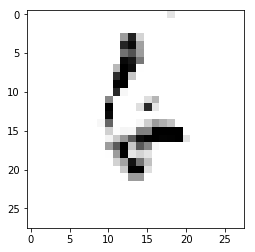

20120
d_loss_real:
215.298
d_loss_fake:
1043.69
20140
d_loss_real:
432.444
d_loss_fake:
792.662
20160
d_loss_real:
212.385
d_loss_fake:
531.962
20180
d_loss_real:
264.439
d_loss_fake:
724.65
20200
d_loss_real:
404.787
d_loss_fake:
831.191


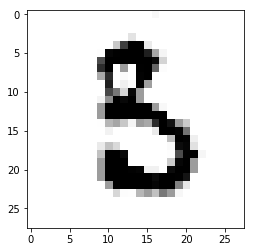

20220
d_loss_real:
253.306
d_loss_fake:
1292.28
20240
d_loss_real:
179.621
d_loss_fake:
494.083
20260
d_loss_real:
299.519
d_loss_fake:
483.292
20280
d_loss_real:
346.339
d_loss_fake:
1067.37
20300
d_loss_real:
257.755
d_loss_fake:
1125.39


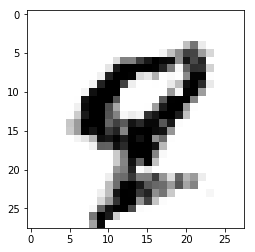

20320
d_loss_real:
301.03
d_loss_fake:
575.375
20340
d_loss_real:
225.691
d_loss_fake:
645.178
20360
d_loss_real:
439.179
d_loss_fake:
706.388
20380
d_loss_real:
393.767
d_loss_fake:
731.703
20400
d_loss_real:
493.739
d_loss_fake:
308.921


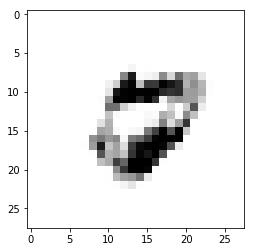

20420
d_loss_real:
144.166
d_loss_fake:
574.812
20440
d_loss_real:
327.195
d_loss_fake:
625.363
20460
d_loss_real:
437.232
d_loss_fake:
811.22
20480
d_loss_real:
252.9
d_loss_fake:
1013.63
20500
d_loss_real:
201.839
d_loss_fake:
361.397


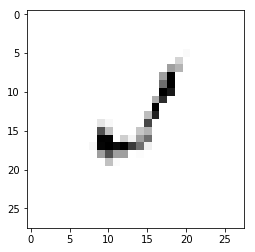

20520
d_loss_real:
201.443
d_loss_fake:
551.762
20540
d_loss_real:
118.689
d_loss_fake:
1172.25
20560
d_loss_real:
600.78
d_loss_fake:
772.894
20580
d_loss_real:
292.609
d_loss_fake:
531.421
20600
d_loss_real:
262.969
d_loss_fake:
85.7175


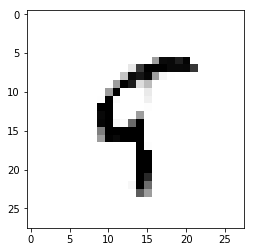

20620
d_loss_real:
316.992
d_loss_fake:
677.573
20640
d_loss_real:
414.469
d_loss_fake:
742.453
20660
d_loss_real:
167.345
d_loss_fake:
1049.65
20680
d_loss_real:
109.56
d_loss_fake:
637.629
20700
d_loss_real:
262.309
d_loss_fake:
659.685


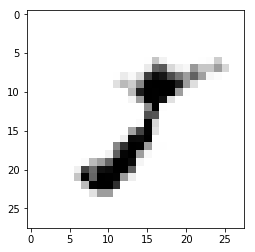

20720
d_loss_real:
200.658
d_loss_fake:
933.232
20740
d_loss_real:
352.566
d_loss_fake:
872.086
20760
d_loss_real:
246.745
d_loss_fake:
766.203
20780
d_loss_real:
204.908
d_loss_fake:
604.868
20800
d_loss_real:
305.269
d_loss_fake:
291.813


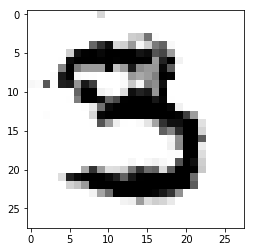

20820
d_loss_real:
400.148
d_loss_fake:
63.3703
20840
d_loss_real:
137.463
d_loss_fake:
953.141
20860
d_loss_real:
74.7032
d_loss_fake:
327.597
20880
d_loss_real:
427.578
d_loss_fake:
614.134
20900
d_loss_real:
317.257
d_loss_fake:
843.847


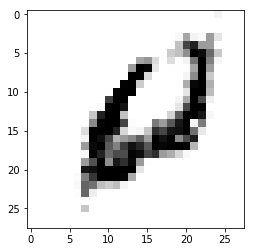

20920
d_loss_real:
328.651
d_loss_fake:
970.129
20940
d_loss_real:
297.888
d_loss_fake:
1029.36
20960
d_loss_real:
255.253
d_loss_fake:
701.428
20980
d_loss_real:
62.6922
d_loss_fake:
1361.78
21000
d_loss_real:
196.525
d_loss_fake:
1021.84


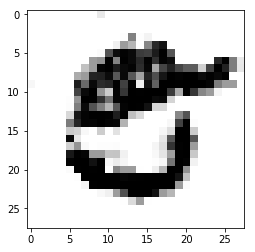

21020
d_loss_real:
586.325
d_loss_fake:
495.295
21040
d_loss_real:
166.448
d_loss_fake:
960.684
21060
d_loss_real:
152.198
d_loss_fake:
1129.91
21080
d_loss_real:
200.094
d_loss_fake:
1138.43
21100
d_loss_real:
440.927
d_loss_fake:
683.724


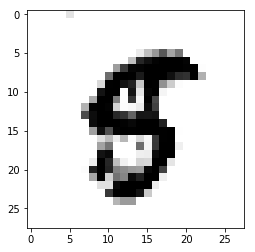

21120
d_loss_real:
434.229
d_loss_fake:
849.678
21140
d_loss_real:
175.072
d_loss_fake:
874.219
21160
d_loss_real:
194.784
d_loss_fake:
1084.54
21180
d_loss_real:
282.684
d_loss_fake:
1136.41
21200
d_loss_real:
163.271
d_loss_fake:
1140.94


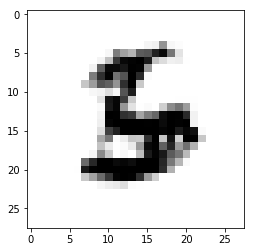

21220
d_loss_real:
187.706
d_loss_fake:
969.749
21240
d_loss_real:
160.324
d_loss_fake:
1032.18
21260
d_loss_real:
254.684
d_loss_fake:
1090.38
21280
d_loss_real:
252.904
d_loss_fake:
1116.91
21300
d_loss_real:
253.023
d_loss_fake:
747.04


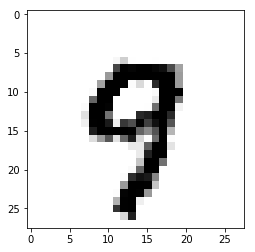

21320
d_loss_real:
291.889
d_loss_fake:
907.532
21340
d_loss_real:
304.124
d_loss_fake:
1022.06
21360
d_loss_real:
219.979
d_loss_fake:
1112.2
21380
d_loss_real:
260.889
d_loss_fake:
630.288
21400
d_loss_real:
376.105
d_loss_fake:
737.744


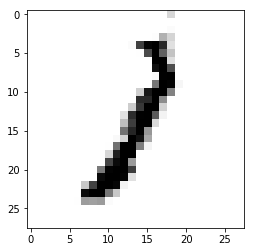

21420
d_loss_real:
359.007
d_loss_fake:
972.01
21440
d_loss_real:
526.012
d_loss_fake:
776.205
21460
d_loss_real:
180.183
d_loss_fake:
713.582
21480
d_loss_real:
370.757
d_loss_fake:
531.769
21500
d_loss_real:
475.205
d_loss_fake:
1070.54


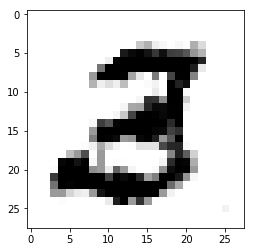

21520
d_loss_real:
434.112
d_loss_fake:
913.681
21540
d_loss_real:
182.234
d_loss_fake:
1087.85
21560
d_loss_real:
178.74
d_loss_fake:
457.997
21580
d_loss_real:
304.01
d_loss_fake:
784.38
21600
d_loss_real:
487.952
d_loss_fake:
928.31


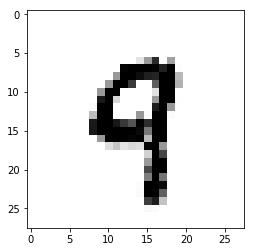

21620
d_loss_real:
448.597
d_loss_fake:
1021.64
21640
d_loss_real:
156.701
d_loss_fake:
714.3
21660
d_loss_real:
204.752
d_loss_fake:
995.729
21680
d_loss_real:
326.103
d_loss_fake:
1133.8
21700
d_loss_real:
332.683
d_loss_fake:
1086.95


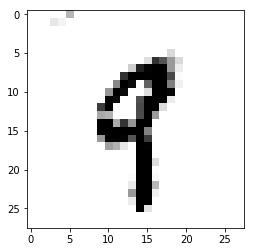

21720
d_loss_real:
323.142
d_loss_fake:
902.424
21740
d_loss_real:
178.848
d_loss_fake:
578.127
21760
d_loss_real:
241.513
d_loss_fake:
638.533
21780
d_loss_real:
353.759
d_loss_fake:
1182.18
21800
d_loss_real:
535.479
d_loss_fake:
2716.97


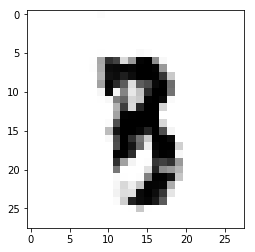

21820
d_loss_real:
255.658
d_loss_fake:
1183.5
21840
d_loss_real:
235.14
d_loss_fake:
1138.94
21860
d_loss_real:
367.419
d_loss_fake:
774.655
21880
d_loss_real:
343.605
d_loss_fake:
1223.83
21900
d_loss_real:
511.87
d_loss_fake:
836.992


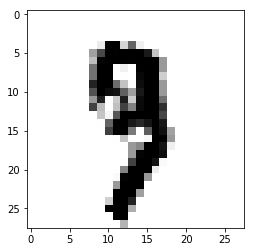

21920
d_loss_real:
484.692
d_loss_fake:
861.049
21940
d_loss_real:
370.698
d_loss_fake:
383.396
21960
d_loss_real:
411.846
d_loss_fake:
456.952
21980
d_loss_real:
329.589
d_loss_fake:
1218.72
22000
d_loss_real:
366.343
d_loss_fake:
1052.38


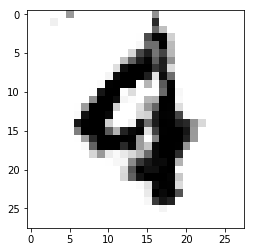

22020
d_loss_real:
183.269
d_loss_fake:
1076.83
22040
d_loss_real:
186.345
d_loss_fake:
642.28
22060
d_loss_real:
383.13
d_loss_fake:
793.348
22080
d_loss_real:
460.16
d_loss_fake:
1039.21
22100
d_loss_real:
550.052
d_loss_fake:
870.646


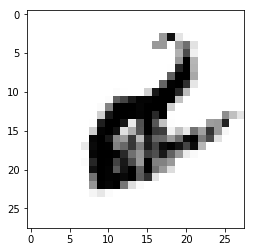

22120
d_loss_real:
134.974
d_loss_fake:
1237.5
22140
d_loss_real:
277.444
d_loss_fake:
493.03
22160
d_loss_real:
420.566
d_loss_fake:
1090.23
22180
d_loss_real:
293.446
d_loss_fake:
1067.9
22200
d_loss_real:
313.273
d_loss_fake:
2403.79


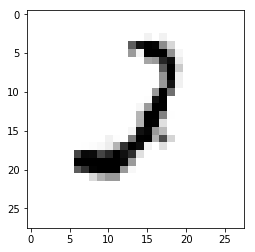

22220
d_loss_real:
254.294
d_loss_fake:
971.886
22240
d_loss_real:
226.697
d_loss_fake:
479.382
22260
d_loss_real:
218.747
d_loss_fake:
1051.92
22280
d_loss_real:
322.729
d_loss_fake:
2543.21
22300
d_loss_real:
456.094
d_loss_fake:
1125.94


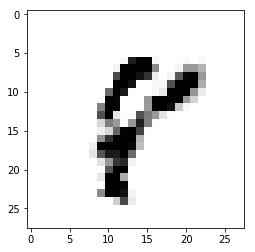

22320
d_loss_real:
280.16
d_loss_fake:
963.519
22340
d_loss_real:
276.846
d_loss_fake:
897.557
22360
d_loss_real:
289.891
d_loss_fake:
1571.81
22380
d_loss_real:
277.92
d_loss_fake:
1224.53
22400
d_loss_real:
383.124
d_loss_fake:
1120.27


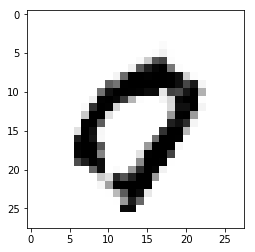

22420
d_loss_real:
259.446
d_loss_fake:
826.838
22440
d_loss_real:
297.416
d_loss_fake:
831.732
22460
d_loss_real:
364.109
d_loss_fake:
748.355
22480
d_loss_real:
435.127
d_loss_fake:
904.689
22500
d_loss_real:
261.611
d_loss_fake:
1125.01


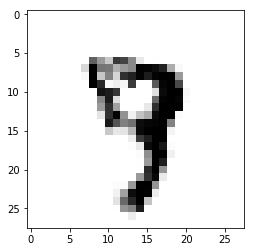

22520
d_loss_real:
367.796
d_loss_fake:
761.081
22540
d_loss_real:
307.166
d_loss_fake:
1031.48
22560
d_loss_real:
488.633
d_loss_fake:
1191.91
22580
d_loss_real:
426.538
d_loss_fake:
2041.59
22600
d_loss_real:
161.536
d_loss_fake:
902.967


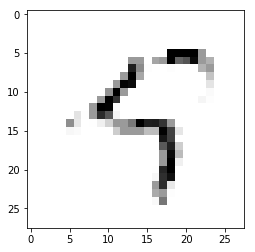

22620
d_loss_real:
324.353
d_loss_fake:
733.509
22640
d_loss_real:
360.018
d_loss_fake:
89.3818
22660
d_loss_real:
566.794
d_loss_fake:
861.269
22680
d_loss_real:
95.8664
d_loss_fake:
1318.17
22700
d_loss_real:
232.575
d_loss_fake:
849.508


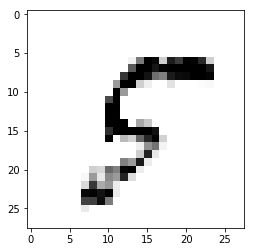

22720
d_loss_real:
479.598
d_loss_fake:
794.779
22740
d_loss_real:
300.964
d_loss_fake:
1192.76
22760
d_loss_real:
396.444
d_loss_fake:
930.765
22780
d_loss_real:
572.547
d_loss_fake:
697.452
22800
d_loss_real:
408.97
d_loss_fake:
934.857


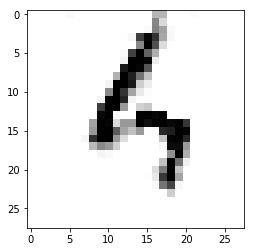

22820
d_loss_real:
221.142
d_loss_fake:
1332.79
22840
d_loss_real:
238.275
d_loss_fake:
1277.32
22860
d_loss_real:
274.492
d_loss_fake:
1286.11
22880
d_loss_real:
287.458
d_loss_fake:
1185.78
22900
d_loss_real:
215.077
d_loss_fake:
1317.53


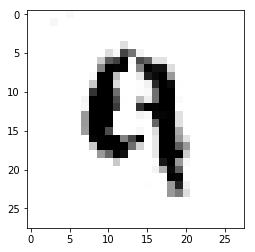

22920
d_loss_real:
346.785
d_loss_fake:
1216.1
22940
d_loss_real:
242.053
d_loss_fake:
1277.4
22960
d_loss_real:
292.383
d_loss_fake:
1199.13
22980
d_loss_real:
187.065
d_loss_fake:
1209.7
23000
d_loss_real:
305.576
d_loss_fake:
1191.74


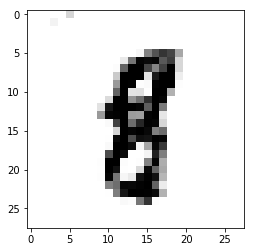

23020
d_loss_real:
348.274
d_loss_fake:
1215.91
23040
d_loss_real:
228.397
d_loss_fake:
1285.04
23060
d_loss_real:
225.408
d_loss_fake:
1110.68
23080
d_loss_real:
255.374
d_loss_fake:
1354.38
23100
d_loss_real:
172.607
d_loss_fake:
1230.65


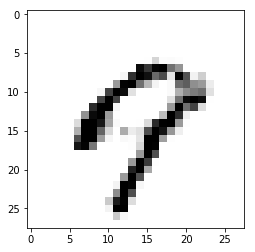

23120
d_loss_real:
222.071
d_loss_fake:
1224.42
23140
d_loss_real:
282.012
d_loss_fake:
1479.46
23160
d_loss_real:
305.073
d_loss_fake:
1183.4
23180
d_loss_real:
208.75
d_loss_fake:
1221.38
23200
d_loss_real:
282.817
d_loss_fake:
1289.48


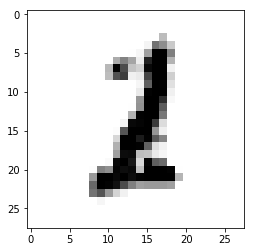

23220
d_loss_real:
322.374
d_loss_fake:
1262.22
23240
d_loss_real:
313.298
d_loss_fake:
1022.86
23260
d_loss_real:
349.707
d_loss_fake:
1224.86
23280
d_loss_real:
465.648
d_loss_fake:
1042.76
23300
d_loss_real:
215.892
d_loss_fake:
1201.78


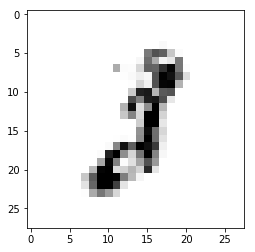

23320
d_loss_real:
532.031
d_loss_fake:
88.209
23340
d_loss_real:
491.795
d_loss_fake:
160.579
23360
d_loss_real:
666.729
d_loss_fake:
997.172
23380
d_loss_real:
496.739
d_loss_fake:
576.784
23400
d_loss_real:
358.052
d_loss_fake:
1055.2


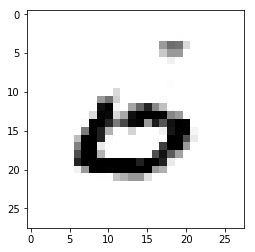

23420
d_loss_real:
616.335
d_loss_fake:
1180.61
23440
d_loss_real:
941.217
d_loss_fake:
687.114
23460
d_loss_real:
223.73
d_loss_fake:
563.937
23480
d_loss_real:
379.701
d_loss_fake:
1646.17
23500
d_loss_real:
692.153
d_loss_fake:
789.717


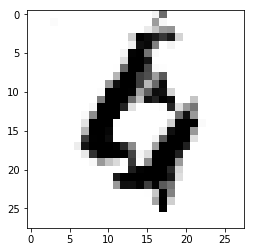

23520
d_loss_real:
228.1
d_loss_fake:
1481.02
23540
d_loss_real:
261.538
d_loss_fake:
486.927
23560
d_loss_real:
315.727
d_loss_fake:
1180.24
23580
d_loss_real:
521.131
d_loss_fake:
1242.04
23600
d_loss_real:
281.373
d_loss_fake:
1567.31


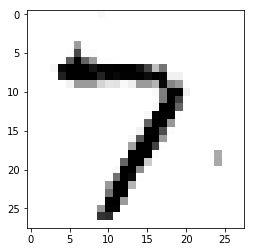

23620
d_loss_real:
277.954
d_loss_fake:
719.95
23640
d_loss_real:
563.749
d_loss_fake:
744.249
23660
d_loss_real:
621.387
d_loss_fake:
1094.56
23680
d_loss_real:
176.914
d_loss_fake:
1238.91
23700
d_loss_real:
182.01
d_loss_fake:
1287.05


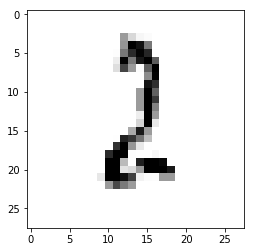

23720
d_loss_real:
412.89
d_loss_fake:
875.691
23740
d_loss_real:
370.189
d_loss_fake:
1410.36
23760
d_loss_real:
676.524
d_loss_fake:
1146.84
23780
d_loss_real:
266.134
d_loss_fake:
949.776
23800
d_loss_real:
524.736
d_loss_fake:
503.895


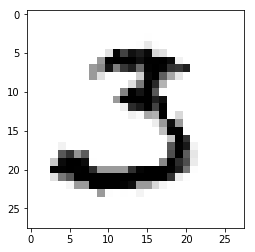

23820
d_loss_real:
479.979
d_loss_fake:
1267.75
23840
d_loss_real:
627.789
d_loss_fake:
1257.04
23860
d_loss_real:
234.61
d_loss_fake:
1377.63
23880
d_loss_real:
395.056
d_loss_fake:
793.343
23900
d_loss_real:
446.238
d_loss_fake:
1276.52


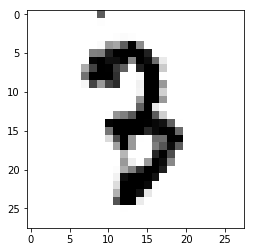

23920
d_loss_real:
392.458
d_loss_fake:
1353.99
23940
d_loss_real:
541.381
d_loss_fake:
1331.71
23960
d_loss_real:
130.414
d_loss_fake:
1042.16
23980
d_loss_real:
384.005
d_loss_fake:
233.449
24000
d_loss_real:
339.704
d_loss_fake:
1454.39


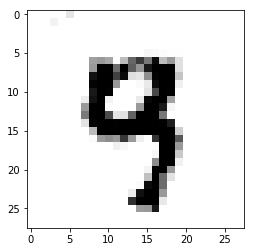

24020
d_loss_real:
599.372
d_loss_fake:
1222.81
24040
d_loss_real:
361.259
d_loss_fake:
258.772
24060
d_loss_real:
409.924
d_loss_fake:
839.235
24080
d_loss_real:
450.18
d_loss_fake:
1242.59
24100
d_loss_real:
712.504
d_loss_fake:
980.501


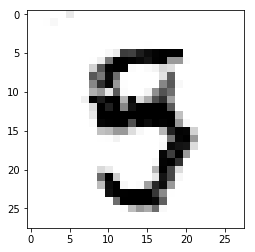

24120
d_loss_real:
265.716
d_loss_fake:
1639.99
24140
d_loss_real:
211.338
d_loss_fake:
613.233
24160
d_loss_real:
321.499
d_loss_fake:
1247.89
24180
d_loss_real:
626.312
d_loss_fake:
2909.35
24200
d_loss_real:
539.548
d_loss_fake:
1277.3


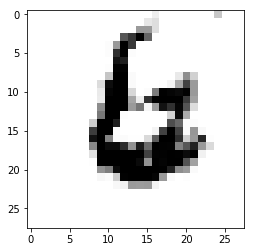

24220
d_loss_real:
231.641
d_loss_fake:
813.609
24240
d_loss_real:
145.315
d_loss_fake:
1017.61
24260
d_loss_real:
375.638
d_loss_fake:
1567.83
24280
d_loss_real:
583.093
d_loss_fake:
39.4559
24300
d_loss_real:
679.831
d_loss_fake:
1043.3


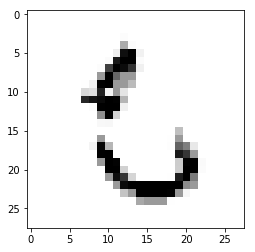

24320
d_loss_real:
286.939
d_loss_fake:
800.469
24340
d_loss_real:
401.246
d_loss_fake:
1137.43
24360
d_loss_real:
489.584
d_loss_fake:
1371.36
24380
d_loss_real:
760.458
d_loss_fake:
1966.8
24400
d_loss_real:
440.593
d_loss_fake:
1153.09


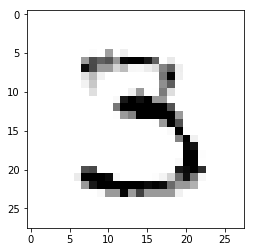

24420
d_loss_real:
216.327
d_loss_fake:
972.165
24440
d_loss_real:
359.345
d_loss_fake:
1275.64
24460
d_loss_real:
377.844
d_loss_fake:
1569.72
24480
d_loss_real:
332.385
d_loss_fake:
1657.03
24500
d_loss_real:
233.89
d_loss_fake:
1258.83


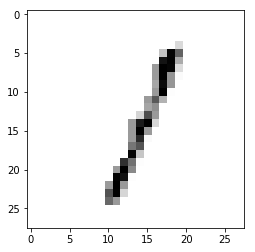

24520
d_loss_real:
337.076
d_loss_fake:
726.518
24540
d_loss_real:
511.201
d_loss_fake:
1720.58
24560
d_loss_real:
728.051
d_loss_fake:
1756.94
24580
d_loss_real:
332.825
d_loss_fake:
484.078
24600
d_loss_real:
363.049
d_loss_fake:
551.08


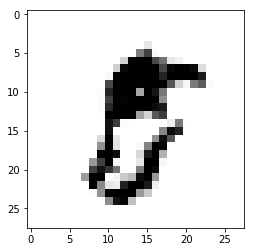

24620
d_loss_real:
694.278
d_loss_fake:
817.673
24640
d_loss_real:
345.072
d_loss_fake:
1587.12
24660
d_loss_real:
351.55
d_loss_fake:
1433.93
24680
d_loss_real:
267.513
d_loss_fake:
1165.68
24700
d_loss_real:
400.66
d_loss_fake:
1169.77


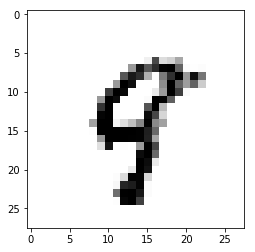

24720
d_loss_real:
339.719
d_loss_fake:
1518.28
24740
d_loss_real:
761.801
d_loss_fake:
1136.84
24760
d_loss_real:
323.329
d_loss_fake:
1393.04
24780
d_loss_real:
440.893
d_loss_fake:
930.879
24800
d_loss_real:
386.927
d_loss_fake:
1247.37


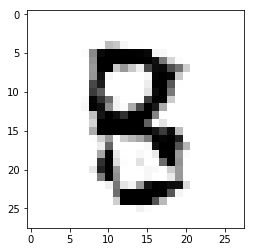

24820
d_loss_real:
523.811
d_loss_fake:
2429.22
24840
d_loss_real:
299.744
d_loss_fake:
1458.76
24860
d_loss_real:
71.4733
d_loss_fake:
1700.24
24880
d_loss_real:
380.755
d_loss_fake:
1101.21
24900
d_loss_real:
347.778
d_loss_fake:
1432.82


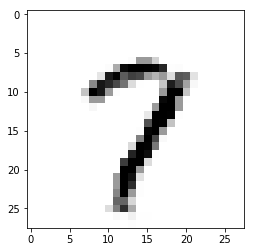

24920
d_loss_real:
305.064
d_loss_fake:
1439.31
24940
d_loss_real:
345.289
d_loss_fake:
1469.74
24960
d_loss_real:
316.297
d_loss_fake:
1467.28
24980
d_loss_real:
423.062
d_loss_fake:
1289.78
25000
d_loss_real:
744.189
d_loss_fake:
802.226


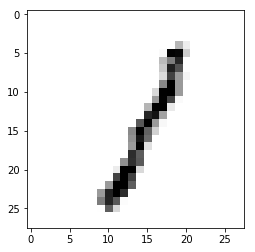

25020
d_loss_real:
419.565
d_loss_fake:
28.8611
25040
d_loss_real:
410.534
d_loss_fake:
353.726
25060
d_loss_real:
371.129
d_loss_fake:
2158.85
25080
d_loss_real:
495.949
d_loss_fake:
1114.56
25100
d_loss_real:
477.925
d_loss_fake:
1148.69


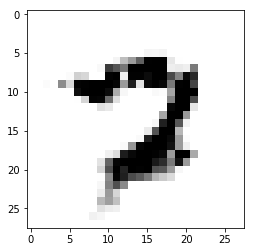

25120
d_loss_real:
435.487
d_loss_fake:
1466.07
25140
d_loss_real:
458.799
d_loss_fake:
2120.99
25160
d_loss_real:
434.435
d_loss_fake:
1005.18
25180
d_loss_real:
187.631
d_loss_fake:
1395.66
25200
d_loss_real:
315.957
d_loss_fake:
1553.57


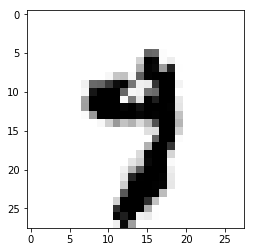

25220
d_loss_real:
476.393
d_loss_fake:
2092.68
25240
d_loss_real:
331.694
d_loss_fake:
1369.42
25260
d_loss_real:
367.585
d_loss_fake:
1411.15
25280
d_loss_real:
370.055
d_loss_fake:
1439.22
25300
d_loss_real:
243.787
d_loss_fake:
402.356


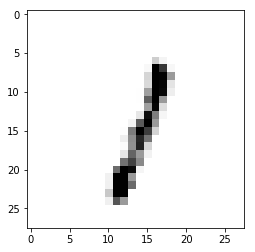

25320
d_loss_real:
263.355
d_loss_fake:
1284.13
25340
d_loss_real:
349.783
d_loss_fake:
1554.71
25360
d_loss_real:
444.508
d_loss_fake:
1454.24
25380
d_loss_real:
327.706
d_loss_fake:
1223.76
25400
d_loss_real:
475.069
d_loss_fake:
1282.4


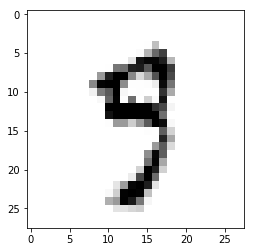

25420
d_loss_real:
536.681
d_loss_fake:
1407.1
25440
d_loss_real:
654.401
d_loss_fake:
15.5357
25460
d_loss_real:
384.876
d_loss_fake:
1017.27
25480
d_loss_real:
484.286
d_loss_fake:
672.755
25500
d_loss_real:
538.2
d_loss_fake:
1268.68


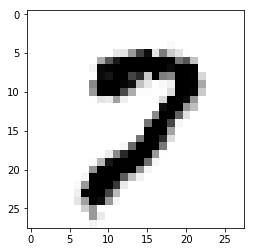

25520
d_loss_real:
326.867
d_loss_fake:
1328.14
25540
d_loss_real:
324.235
d_loss_fake:
1207.12
25560
d_loss_real:
522.93
d_loss_fake:
2233.29
25580
d_loss_real:
537.769
d_loss_fake:
1267.04
25600
d_loss_real:
192.799
d_loss_fake:
1099.66


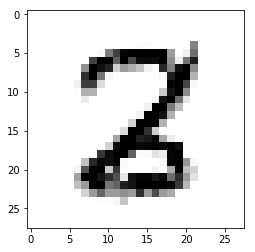

25620
d_loss_real:
491.1
d_loss_fake:
964.121
25640
d_loss_real:
498.66
d_loss_fake:
1414.86
25660
d_loss_real:
240.023
d_loss_fake:
1380.3
25680
d_loss_real:
428.01
d_loss_fake:
965.111
25700
d_loss_real:
429.091
d_loss_fake:
1374.91


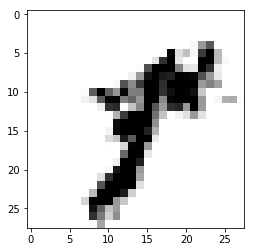

25720
d_loss_real:
482.112
d_loss_fake:
1441.98
25740
d_loss_real:
280.225
d_loss_fake:
845.835
25760
d_loss_real:
567.445
d_loss_fake:
807.83
25780
d_loss_real:
162.21
d_loss_fake:
1711.41
25800
d_loss_real:
595.664
d_loss_fake:
1515.17


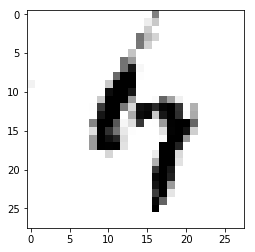

25820
d_loss_real:
389.368
d_loss_fake:
792.553
25840
d_loss_real:
221.585
d_loss_fake:
613.147
25860
d_loss_real:
728.031
d_loss_fake:
1151.16
25880
d_loss_real:
540.583
d_loss_fake:
1325.77
25900
d_loss_real:
378.748
d_loss_fake:
783.835


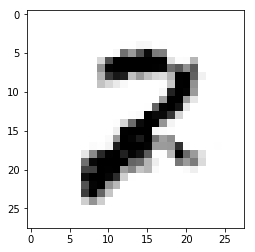

25920
d_loss_real:
341.667
d_loss_fake:
1128.89
25940
d_loss_real:
602.775
d_loss_fake:
2122.65
25960
d_loss_real:
482.933
d_loss_fake:
1609.51
25980
d_loss_real:
205.892
d_loss_fake:
1260.5
26000
d_loss_real:
330.918
d_loss_fake:
1530.78


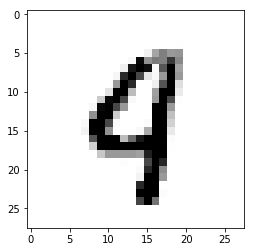

26020
d_loss_real:
306.39
d_loss_fake:
1715.08
26040
d_loss_real:
533.529
d_loss_fake:
1625.96
26060
d_loss_real:
243.163
d_loss_fake:
1005.52
26080
d_loss_real:
435.342
d_loss_fake:
1245.77
26100
d_loss_real:
376.466
d_loss_fake:
1392.26


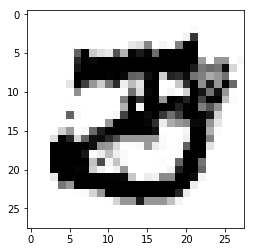

26120
d_loss_real:
351.331
d_loss_fake:
284.674
26140
d_loss_real:
504.503
d_loss_fake:
861.39
26160
d_loss_real:
621.115
d_loss_fake:
1109.9
26180
d_loss_real:
733.561
d_loss_fake:
1251.69
26200
d_loss_real:
312.405
d_loss_fake:
1578.98


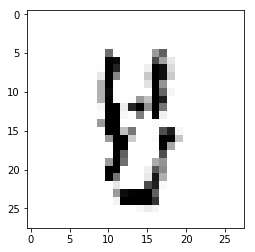

26220
d_loss_real:
175.728
d_loss_fake:
1269.1
26240
d_loss_real:
334.28
d_loss_fake:
1434.08
26260
d_loss_real:
512.652
d_loss_fake:
1614.4
26280
d_loss_real:
193.657
d_loss_fake:
1537.62
26300
d_loss_real:
433.356
d_loss_fake:
1140.24


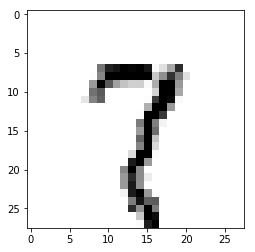

26320
d_loss_real:
506.342
d_loss_fake:
1444.54
26340
d_loss_real:
575.486
d_loss_fake:
1398.78
26360
d_loss_real:
198.708
d_loss_fake:
1404.01
26380
d_loss_real:
367.139
d_loss_fake:
993.831
26400
d_loss_real:
600.097
d_loss_fake:
626.011


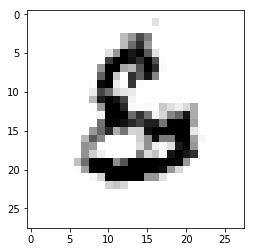

26420
d_loss_real:
493.847
d_loss_fake:
1143.11
26440
d_loss_real:
512.944
d_loss_fake:
1250.02
26460
d_loss_real:
556.948
d_loss_fake:
1053.82
26480
d_loss_real:
553.907
d_loss_fake:
1413.28
26500
d_loss_real:
593.005
d_loss_fake:
432.325


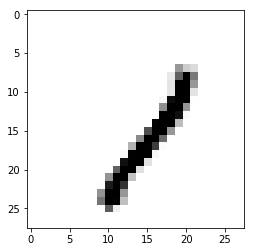

26520
d_loss_real:
441.933
d_loss_fake:
1078.07
26540
d_loss_real:
360.04
d_loss_fake:
1039.66
26560
d_loss_real:
489.647
d_loss_fake:
1478.12
26580
d_loss_real:
516.311
d_loss_fake:
1342.42
26600
d_loss_real:
245.105
d_loss_fake:
1739.13


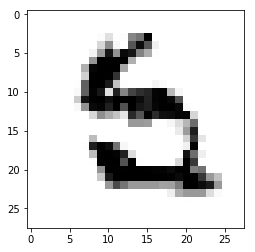

26620
d_loss_real:
302.562
d_loss_fake:
921.686
26640
d_loss_real:
499.344
d_loss_fake:
1568.46
26660
d_loss_real:
441.306
d_loss_fake:
1615.02
26680
d_loss_real:
300.974
d_loss_fake:
1027.32
26700
d_loss_real:
608.115
d_loss_fake:
1058.73


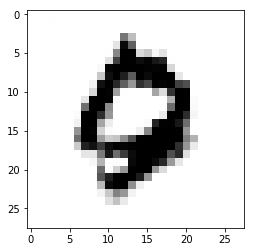

26720
d_loss_real:
435.561
d_loss_fake:
203.839
26740
d_loss_real:
383.322
d_loss_fake:
1516.44
26760
d_loss_real:
412.029
d_loss_fake:
802.499
26780
d_loss_real:
472.746
d_loss_fake:
1050.6
26800
d_loss_real:
509.81
d_loss_fake:
1645.18


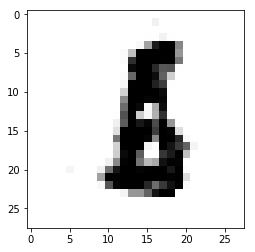

26820
d_loss_real:
695.469
d_loss_fake:
994.815
26840
d_loss_real:
521.355
d_loss_fake:
880.297
26860
d_loss_real:
484.59
d_loss_fake:
1435.94
26880
d_loss_real:
633.795
d_loss_fake:
1432.83
26900
d_loss_real:
679.439
d_loss_fake:
846.17


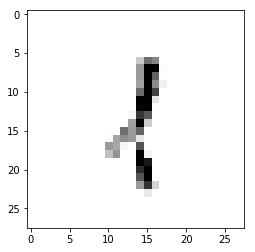

26920
d_loss_real:
368.085
d_loss_fake:
911.149
26940
d_loss_real:
440.834
d_loss_fake:
1329.49
26960
d_loss_real:
744.436
d_loss_fake:
1066.19
26980
d_loss_real:
296.72
d_loss_fake:
1510.0
27000
d_loss_real:
437.092
d_loss_fake:
1092.99


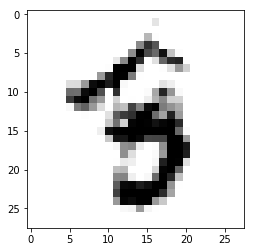

27020
d_loss_real:
533.547
d_loss_fake:
1437.54
27040
d_loss_real:
850.28
d_loss_fake:
1209.39
27060
d_loss_real:
334.681
d_loss_fake:
1240.2
27080
d_loss_real:
677.353
d_loss_fake:
761.266
27100
d_loss_real:
361.258
d_loss_fake:
1699.21


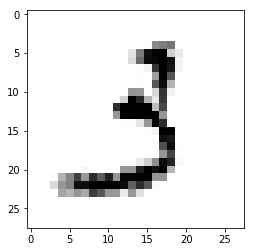

27120
d_loss_real:
592.849
d_loss_fake:
1596.08
27140
d_loss_real:
396.403
d_loss_fake:
1473.63
27160
d_loss_real:
411.559
d_loss_fake:
1294.13
27180
d_loss_real:
425.613
d_loss_fake:
1789.43
27200
d_loss_real:
560.317
d_loss_fake:
2633.07


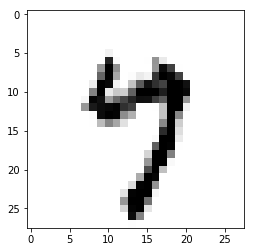

27220
d_loss_real:
512.59
d_loss_fake:
893.316
27240
d_loss_real:
388.494
d_loss_fake:
1066.53
27260
d_loss_real:
461.59
d_loss_fake:
1693.93
27280
d_loss_real:
671.538
d_loss_fake:
401.439
27300
d_loss_real:
587.579
d_loss_fake:
902.36


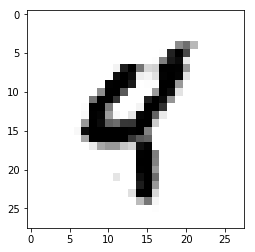

27320
d_loss_real:
458.884
d_loss_fake:
1185.01
27340
d_loss_real:
555.885
d_loss_fake:
1656.67
27360
d_loss_real:
339.458
d_loss_fake:
621.819
27380
d_loss_real:
300.242
d_loss_fake:
1390.49
27400
d_loss_real:
299.23
d_loss_fake:
1189.22


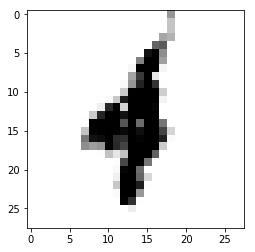

27420
d_loss_real:
371.625
d_loss_fake:
1860.87
27440
d_loss_real:
450.186
d_loss_fake:
318.802
27460
d_loss_real:
457.492
d_loss_fake:
1262.36
27480
d_loss_real:
423.44
d_loss_fake:
2337.37
27500
d_loss_real:
344.576
d_loss_fake:
1701.98


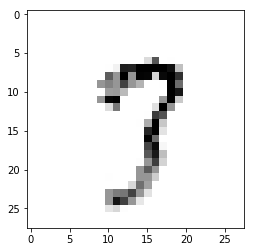

27520
d_loss_real:
413.338
d_loss_fake:
1649.53
27540
d_loss_real:
279.407
d_loss_fake:
1423.38
27560
d_loss_real:
448.247
d_loss_fake:
1444.66
27580
d_loss_real:
560.547
d_loss_fake:
1430.0
27600
d_loss_real:
449.114
d_loss_fake:
1564.08


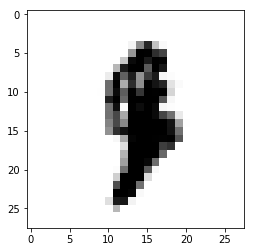

27620
d_loss_real:
530.344
d_loss_fake:
1004.76
27640
d_loss_real:
675.32
d_loss_fake:
1295.28
27660
d_loss_real:
653.327
d_loss_fake:
873.524
27680
d_loss_real:
484.945
d_loss_fake:
1389.43
27700
d_loss_real:
388.353
d_loss_fake:
1047.66


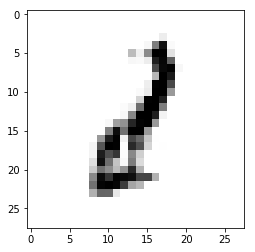

27720
d_loss_real:
297.295
d_loss_fake:
1655.74
27740
d_loss_real:
531.597
d_loss_fake:
1542.6
27760
d_loss_real:
483.175
d_loss_fake:
1215.06
27780
d_loss_real:
471.892
d_loss_fake:
672.813
27800
d_loss_real:
572.422
d_loss_fake:
1524.64


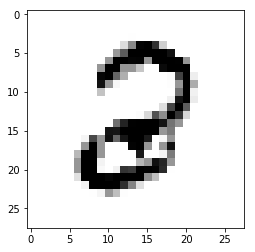

27820
d_loss_real:
808.741
d_loss_fake:
1462.89
27840
d_loss_real:
389.548
d_loss_fake:
1378.04
27860
d_loss_real:
362.272
d_loss_fake:
964.499
27880
d_loss_real:
514.297
d_loss_fake:
1536.49
27900
d_loss_real:
819.193
d_loss_fake:
1110.56


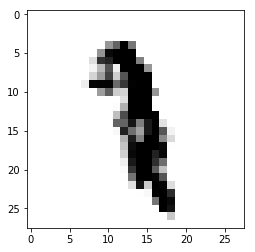

27920
d_loss_real:
287.355
d_loss_fake:
1588.78
27940
d_loss_real:
477.442
d_loss_fake:
504.692
27960
d_loss_real:
490.558
d_loss_fake:
1091.3
27980
d_loss_real:
588.519
d_loss_fake:
1594.69
28000
d_loss_real:
429.536
d_loss_fake:
1684.07


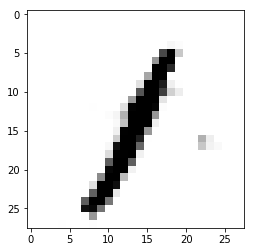

28020
d_loss_real:
397.82
d_loss_fake:
1014.78
28040
d_loss_real:
406.193
d_loss_fake:
1307.95
28060
d_loss_real:
706.565
d_loss_fake:
1239.55
28080
d_loss_real:
783.596
d_loss_fake:
1395.19
28100
d_loss_real:
364.982
d_loss_fake:
648.819


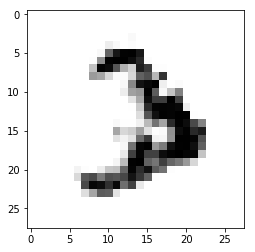

28120
d_loss_real:
526.526
d_loss_fake:
875.439
28140
d_loss_real:
628.814
d_loss_fake:
1672.84
28160
d_loss_real:
970.286
d_loss_fake:
1075.18
28180
d_loss_real:
368.342
d_loss_fake:
1403.01
28200
d_loss_real:
356.074
d_loss_fake:
657.98


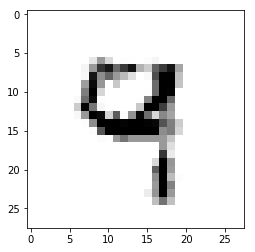

28220
d_loss_real:
504.31
d_loss_fake:
1889.45
28240
d_loss_real:
441.909
d_loss_fake:
1859.31
28260
d_loss_real:
631.439
d_loss_fake:
1447.03
28280
d_loss_real:
309.164
d_loss_fake:
1367.36
28300
d_loss_real:
620.875
d_loss_fake:
1229.87


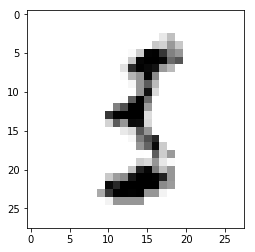

28320
d_loss_real:
520.453
d_loss_fake:
1914.22
28340
d_loss_real:
291.759
d_loss_fake:
1975.48
28360
d_loss_real:
409.658
d_loss_fake:
1490.78
28380
d_loss_real:
398.364
d_loss_fake:
894.988
28400
d_loss_real:
561.195
d_loss_fake:
1639.85


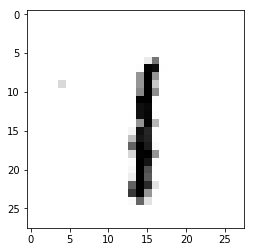

28420
d_loss_real:
1014.73
d_loss_fake:
1119.4
28440
d_loss_real:
708.241
d_loss_fake:
1136.73
28460
d_loss_real:
228.626
d_loss_fake:
1217.23
28480
d_loss_real:
563.803
d_loss_fake:
956.599
28500
d_loss_real:
596.7
d_loss_fake:
1873.79


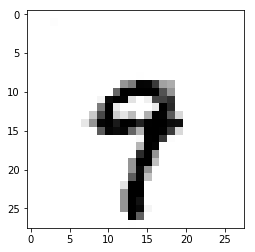

28520
d_loss_real:
611.174
d_loss_fake:
1858.13
28540
d_loss_real:
253.419
d_loss_fake:
1716.4
28560
d_loss_real:
216.121
d_loss_fake:
1470.27
28580
d_loss_real:
399.725
d_loss_fake:
1546.11
28600
d_loss_real:
355.802
d_loss_fake:
1866.72


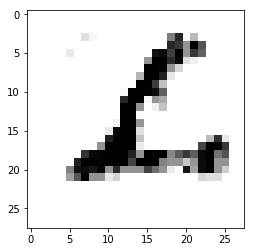

28620
d_loss_real:
619.355
d_loss_fake:
1794.12
28640
d_loss_real:
598.712
d_loss_fake:
943.362
28660
d_loss_real:
516.041
d_loss_fake:
960.532
28680
d_loss_real:
610.082
d_loss_fake:
3604.15
28700
d_loss_real:
700.108
d_loss_fake:
1501.74


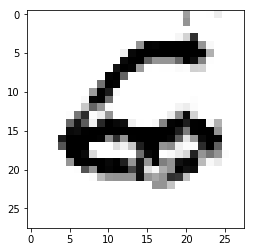

28720
d_loss_real:
386.085
d_loss_fake:
1754.2
28740
d_loss_real:
361.513
d_loss_fake:
998.285
28760
d_loss_real:
589.193
d_loss_fake:
1037.47
28780
d_loss_real:
518.989
d_loss_fake:
1688.35
28800
d_loss_real:
561.85
d_loss_fake:
1379.93


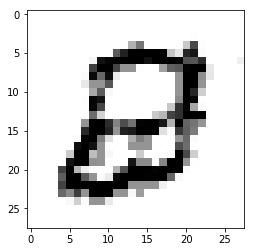

28820
d_loss_real:
411.061
d_loss_fake:
1413.52
28840
d_loss_real:
512.502
d_loss_fake:
814.099
28860
d_loss_real:
485.455
d_loss_fake:
1095.74
28880
d_loss_real:
313.809
d_loss_fake:
1809.47
28900
d_loss_real:
637.172
d_loss_fake:
1438.94


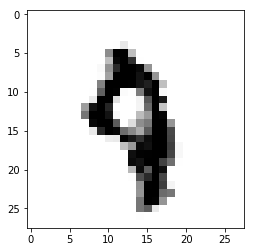

28920
d_loss_real:
365.787
d_loss_fake:
1714.73
28940
d_loss_real:
296.662
d_loss_fake:
102.176
28960
d_loss_real:
377.6
d_loss_fake:
1623.98
28980
d_loss_real:
159.189
d_loss_fake:
2130.1
29000
d_loss_real:
359.313
d_loss_fake:
1607.8


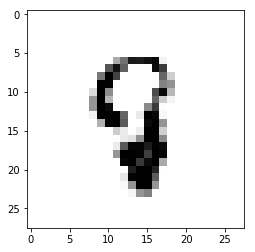

29020
d_loss_real:
255.088
d_loss_fake:
1535.7
29040
d_loss_real:
475.763
d_loss_fake:
1186.49
29060
d_loss_real:
401.73
d_loss_fake:
1500.19
29080
d_loss_real:
511.289
d_loss_fake:
1728.22
29100
d_loss_real:
271.055
d_loss_fake:
1680.09


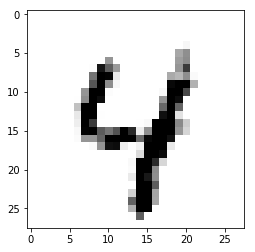

29120
d_loss_real:
365.469
d_loss_fake:
1306.64
29140
d_loss_real:
512.757
d_loss_fake:
846.867
29160
d_loss_real:
664.271
d_loss_fake:
1370.67
29180
d_loss_real:
550.134
d_loss_fake:
1472.29
29200
d_loss_real:
304.788
d_loss_fake:
1645.67


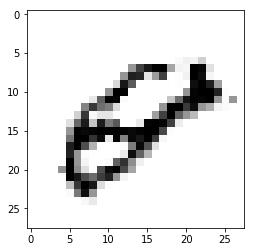

29220
d_loss_real:
371.435
d_loss_fake:
1000.79
29240
d_loss_real:
512.177
d_loss_fake:
1696.18
29260
d_loss_real:
280.09
d_loss_fake:
1972.72
29280
d_loss_real:
544.832
d_loss_fake:
1416.0
29300
d_loss_real:
307.984
d_loss_fake:
1004.39


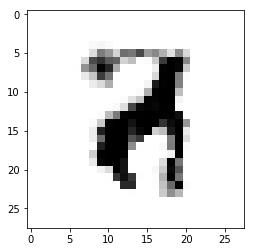

29320
d_loss_real:
691.565
d_loss_fake:
39.4799
29340
d_loss_real:
707.728
d_loss_fake:
1435.7
29360
d_loss_real:
691.509
d_loss_fake:
1599.31
29380
d_loss_real:
455.59
d_loss_fake:
1337.25
29400
d_loss_real:
471.269
d_loss_fake:
1750.32


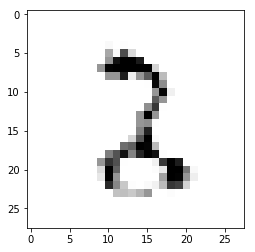

29420
d_loss_real:
666.254
d_loss_fake:
774.864
29440
d_loss_real:
828.769
d_loss_fake:
1135.43
29460
d_loss_real:
457.981
d_loss_fake:
1745.4
29480
d_loss_real:
440.967
d_loss_fake:
1805.02
29500
d_loss_real:
283.047
d_loss_fake:
1723.39


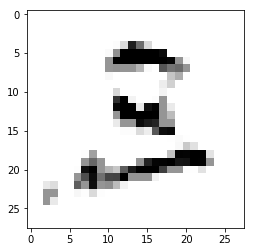

29520
d_loss_real:
686.188
d_loss_fake:
1339.1
29540
d_loss_real:
602.349
d_loss_fake:
1480.34
29560
d_loss_real:
389.423
d_loss_fake:
1986.37
29580
d_loss_real:
410.131
d_loss_fake:
794.274
29600
d_loss_real:
611.951
d_loss_fake:
1128.35


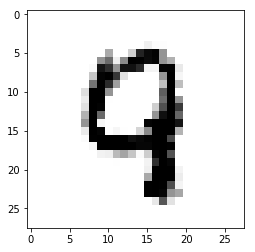

29620
d_loss_real:
455.408
d_loss_fake:
1626.6
29640
d_loss_real:
888.242
d_loss_fake:
1295.89
29660
d_loss_real:
424.762
d_loss_fake:
1304.77
29680
d_loss_real:
384.443
d_loss_fake:
665.957
29700
d_loss_real:
276.695
d_loss_fake:
1416.12


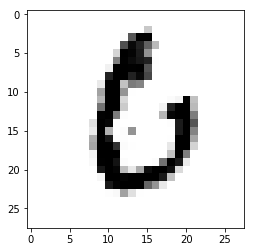

29720
d_loss_real:
681.714
d_loss_fake:
1326.39
29740
d_loss_real:
646.165
d_loss_fake:
1325.11
29760
d_loss_real:
567.58
d_loss_fake:
999.533
29780
d_loss_real:
511.31
d_loss_fake:
1494.96
29800
d_loss_real:
403.143
d_loss_fake:
1449.07


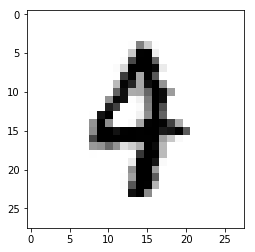

29820
d_loss_real:
474.873
d_loss_fake:
1699.64
29840
d_loss_real:
576.565
d_loss_fake:
1467.76
29860
d_loss_real:
322.074
d_loss_fake:
1094.44
29880
d_loss_real:
375.989
d_loss_fake:
938.696
29900
d_loss_real:
666.59
d_loss_fake:
1253.24


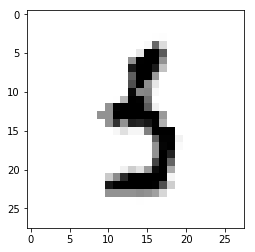

29920
d_loss_real:
521.628
d_loss_fake:
1259.73
29940
d_loss_real:
469.418
d_loss_fake:
1484.59
29960
d_loss_real:
300.747
d_loss_fake:
1082.13
29980
d_loss_real:
497.567
d_loss_fake:
1028.11
30000
d_loss_real:
336.936
d_loss_fake:
1546.45


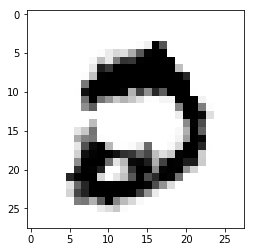

30020
d_loss_real:
725.001
d_loss_fake:
1207.69
30040
d_loss_real:
495.822
d_loss_fake:
1034.87
30060
d_loss_real:
388.598
d_loss_fake:
72.9806
30080
d_loss_real:
205.649
d_loss_fake:
464.93
30100
d_loss_real:
392.554
d_loss_fake:
1263.03


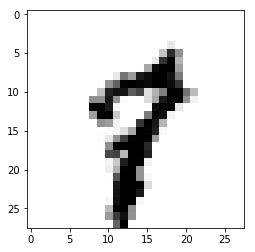

30120
d_loss_real:
386.892
d_loss_fake:
417.475
30140
d_loss_real:
493.543
d_loss_fake:
247.271
30160
d_loss_real:
279.276
d_loss_fake:
1386.93
30180
d_loss_real:
261.689
d_loss_fake:
607.633
30200
d_loss_real:
270.454
d_loss_fake:
409.21


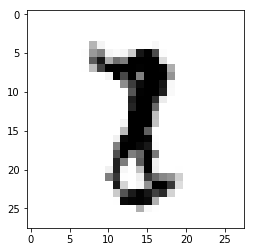

30220
d_loss_real:
272.957
d_loss_fake:
1533.7
30240
d_loss_real:
401.155
d_loss_fake:
349.659
30260
d_loss_real:
274.607
d_loss_fake:
342.357
30280
d_loss_real:
620.484
d_loss_fake:
176.523
30300
d_loss_real:
321.047
d_loss_fake:
420.505


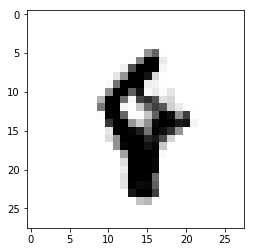

30320
d_loss_real:
319.484
d_loss_fake:
1803.25
30340
d_loss_real:
207.477
d_loss_fake:
1571.95
30360
d_loss_real:
249.167
d_loss_fake:
1649.02
30380
d_loss_real:
413.098
d_loss_fake:
1711.31
30400
d_loss_real:
191.208
d_loss_fake:
1822.84


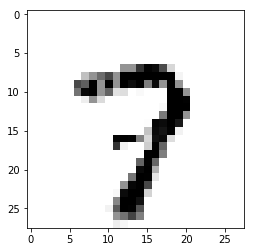

30420
d_loss_real:
108.244
d_loss_fake:
1553.29
30440
d_loss_real:
321.163
d_loss_fake:
1347.45
30460
d_loss_real:
266.736
d_loss_fake:
445.133
30480
d_loss_real:
218.678
d_loss_fake:
1731.44
30500
d_loss_real:
164.11
d_loss_fake:
1099.89


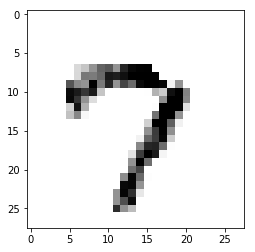

30520
d_loss_real:
457.33
d_loss_fake:
245.25
30540
d_loss_real:
111.902
d_loss_fake:
1755.69
30560
d_loss_real:
357.314
d_loss_fake:
263.015
30580
d_loss_real:
508.228
d_loss_fake:
1414.47
30600
d_loss_real:
380.696
d_loss_fake:
217.118


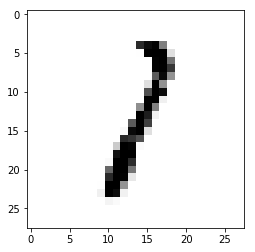

30620
d_loss_real:
271.769
d_loss_fake:
1078.19
30640
d_loss_real:
332.184
d_loss_fake:
1653.75
30660
d_loss_real:
300.87
d_loss_fake:
1410.34
30680
d_loss_real:
346.281
d_loss_fake:
1321.75
30700
d_loss_real:
383.628
d_loss_fake:
1528.85


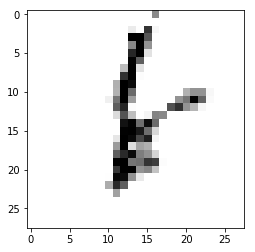

30720
d_loss_real:
661.648
d_loss_fake:
19.2608
30740
d_loss_real:
543.876
d_loss_fake:
1506.49
30760
d_loss_real:
231.375
d_loss_fake:
1717.29
30780
d_loss_real:
489.737
d_loss_fake:
1700.59
30800
d_loss_real:
748.948
d_loss_fake:
576.749


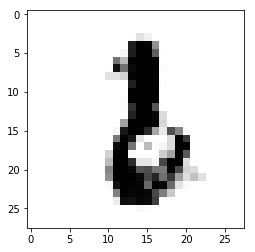

30820
d_loss_real:
586.903
d_loss_fake:
1481.86
30840
d_loss_real:
137.407
d_loss_fake:
1742.47
30860
d_loss_real:
315.417
d_loss_fake:
1897.21
30880
d_loss_real:
257.191
d_loss_fake:
1676.25
30900
d_loss_real:
280.545
d_loss_fake:
457.147


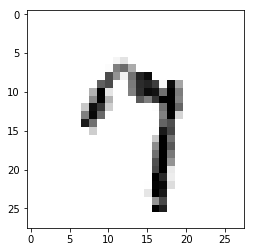

30920
d_loss_real:
87.2809
d_loss_fake:
2085.39
30940
d_loss_real:
307.329
d_loss_fake:
1617.52
30960
d_loss_real:
376.059
d_loss_fake:
1498.83
30980
d_loss_real:
656.42
d_loss_fake:
1350.16
31000
d_loss_real:
232.637
d_loss_fake:
1481.0


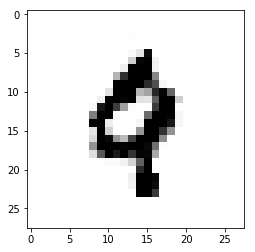

31020
d_loss_real:
555.98
d_loss_fake:
890.631


KeyboardInterrupt: 

In [12]:
import numpy as np
import datetime
session.run(tf.global_variables_initializer())

batch_size = 100
z_dimensions = 100
for i in range(100000):
    real_image_batch, _ = mnist.train.next_batch(batch_size)
    real_image_batch = real_image_batch.reshape([-1, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _, __, d_loss_real, d_loss_fake = session.run([optimizer_d_real, optimizer_d_fake, d_cost_real, d_cost_fake],
                                           {x_placeholder: real_image_batch, z_placeholder:z_batch})
    
    _ = session.run([optimizer_g], feed_dict={z_placeholder:z_batch})

    if i % 20 == 0:
        print i
        print "d_loss_real:"
        print d_loss_real
        print "d_loss_fake:"
        print d_loss_fake
    if i % 100 == 0:
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, z_dimensions, 1, True)
        images = session.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()